# Identify permitted and potentially unpermitted attached and detached units in San Jose (2020)

In [1]:
from esda import shape as shapestats
import json
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
import math
import seaborn as sns
from tqdm import tqdm

In [2]:
# Import functions for the polygon pipeline
%run ADU_permit_matching-polygon-pipeline.ipynb import (process_OSM_data, \
                                                        compare_buildings, \
                                                        merge_buildings,\
                                                        get_inference_main_building, \
                                                        identify_main_buildings, \
                                                        compute_largest_protruding_poly, \
                                                        compare_building_footprint, \
                                                        flatten_geometries, \
                                                        run_osm_apn, \
                                                        run_osm_apn_full_detail, \
                                                        get_tile_dicts_all_years, load_sources)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
# File paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Permit-Matching')
SJ_RES_PARCELS_FP = os.path.join(INPUT_FP, 'inputs', 'san_jose_parcels_res.geojson')
ZONING_FP = os.path.join(OAK_FP, 'san_jose_suppl', 'san_jose_Zoning_Districts.geojson')
BUILD_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-{}', 'inference_building_processed')
OSM_FP = os.path.join(OAK_FP, 'outputs', 'cbg-inference-2020', 'osm_building_processed')

In [5]:
# Resources used to display imagery for each parcel
TIF_FP, INFERENCES_DIR, IMG_FP = load_sources()
tile_bounds_dict_all, tiles_gdf = get_tile_dicts_all_years(oak_fp=OAK_FP, inferences_dir=INFERENCES_DIR)

100%|██████████| 3074/3074 [00:00<00:00, 13453.93it/s]


In [6]:
# Load data
# * Residential parcels
sj_parcels_res = gpd.read_file(SJ_RES_PARCELS_FP)
sj_parcels_res = sj_parcels_res[sj_parcels_res['APN'].notna()]

# * Zoning
sj_zoning = gpd.read_file(ZONING_FP)
sj_residential = sj_zoning[(sj_zoning['ZONING'].str.contains('R-1')) | (sj_zoning['ZONING'].str.contains('R-2')) |\
         ((sj_zoning['ZONING'].str.contains('R-M')) & (sj_zoning['ZONING'] != 'R-MH'))]

# * parcel+permit
sj_parcel_permit = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_found.csv'))
sj_permit_noparcel = pd.read_csv(os.path.join(INPUT_FP, 'outputs', 'parcel_permit_notfound.csv'))
sj_parcel_permit['geometry_parcel'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_parcel'])
sj_parcel_permit['geometry_permit'] = gpd.GeoSeries.from_wkt(sj_parcel_permit['geometry_permit'])
sj_permit_noparcel['geometry'] = gpd.GeoSeries.from_wkt(sj_permit_noparcel['geometry'])

# Functions

In [8]:
def parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    # def mask_buildings(df, parcel_bounds):
    #   df_out = df.sjoin(parcel_bounds[['geometry','geom']])
    #   # print(df_out)
    #   df_out['iou'] = df_out['geometry'].intersection(df_out['geom']).area/df_out['geom'].area
    #   df_out = df_out[df_out['iou'] > 0.7]
    #   return df_out
    
    # Permits
    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.7]
        if df_out.empty:
            return None
        else:
            return df_out
        
    if len(parcel_bounds['geometry']) == 0:
        return None, None, None, permits_parcels

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

# Visual tests

## Debug a particular parcel

In [101]:
# Import functions for the polygon pipeline
%run ADU_permit_matching-polygon-pipeline.ipynb

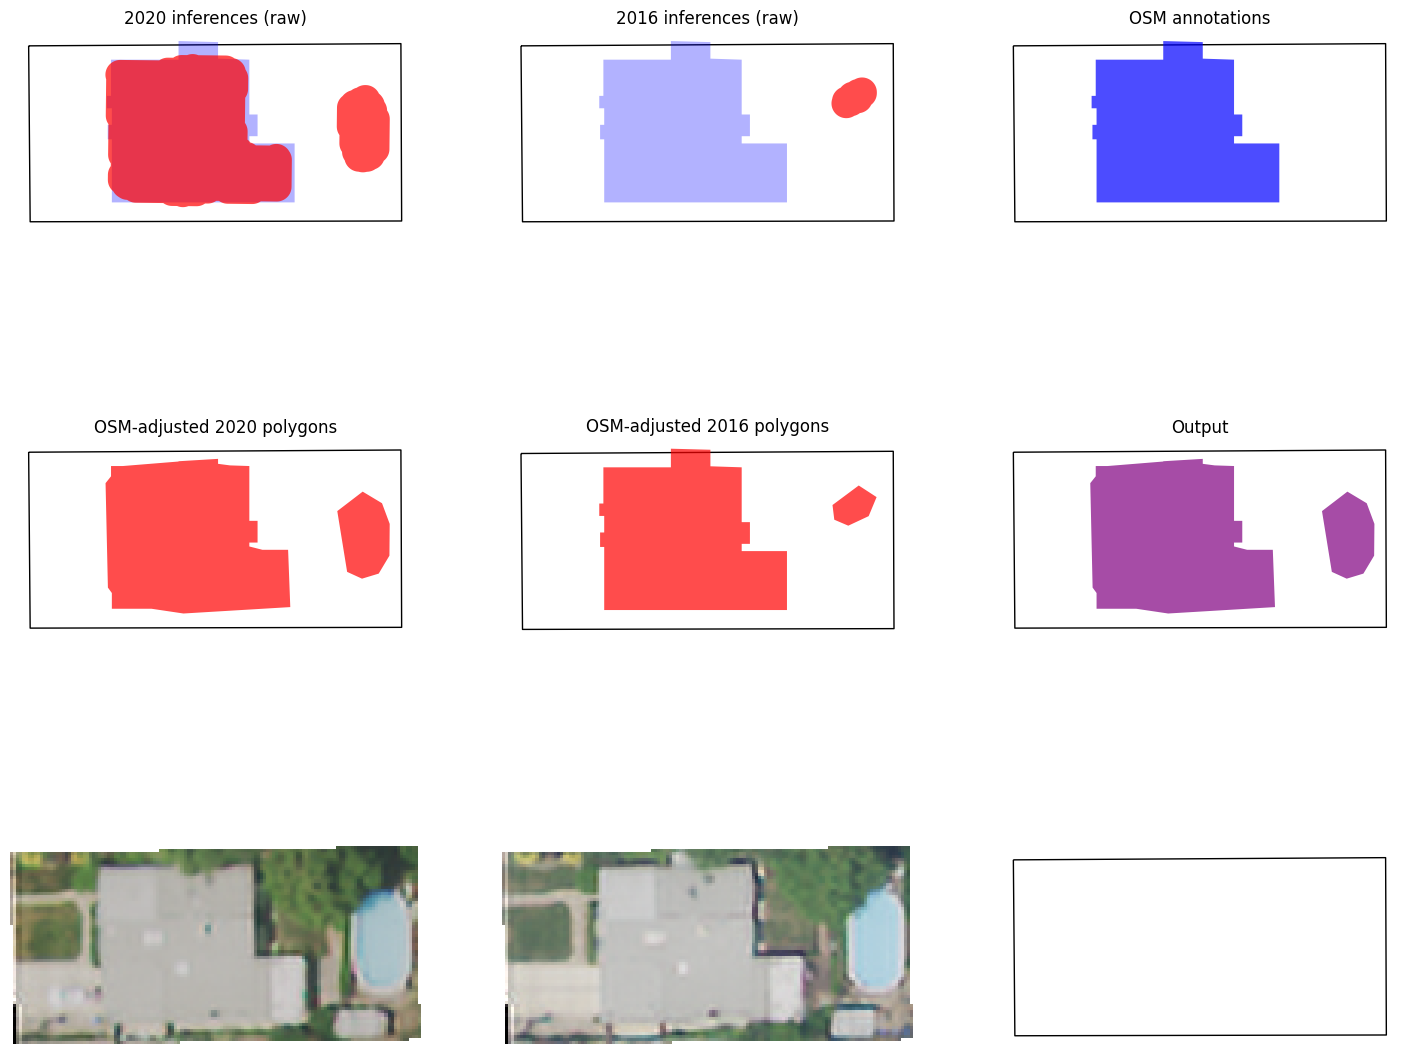

main_building_flag  OSM_flag  expansion_OSM_flag diff_OSM_value  \
0                True     False               False            0.0   
1               False     False                True      39.462777   

   expansion_2016_flag  diff_2016_value  \
0                False         0.000000   
1                False        29.333078   

                                            geometry        area  
0  POLYGON ((-121.94130 37.24781, -121.94129 37.2...  270.195985  
1  POLYGON ((-121.94116 37.24776, -121.94112 37.2...   39.462777

In [106]:
run_osm_apn_full_detail(
    parcel_apn='42116035', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})

In [103]:
parcel_apn='42116035'
min_area_thresh = 30
flatten_threshold=0.85

inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]


gpd_cols = [
    'main_building_flag', 'OSM_flag', 'expansion_OSM_flag', 'diff_OSM_value',
    'expansion_2016_flag', 'diff_2016_value', 'geometry']
parcel_buildings = gpd.GeoDataFrame(geometry=[], columns=gpd_cols)

# Drop OSM index_left column
if osm_buildings_parcel is not None and 'index_left' in osm_buildings_parcel.columns:
    osm_buildings_parcel.drop('index_left', axis=1, inplace=True)

# Identify main buildings
parcel_builds, parcel_main_geoms = identify_main_buildings(
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, parcel_bounds)
ib_2020_parcel, ib_2016_parcel, osm_parcel = parcel_builds
ib_2020_main_geom, ib_2016_main_geom, osm_main_geom = parcel_main_geoms

print(ib_2016_parcel)
# Merge buildings with OSM annotations
ib_2016_parcel = merge_buildings(
    gdf=ib_2016_parcel, comp=osm_parcel, 
    area_threshold_expansion=min_area_thresh, flatten_threshold=flatten_threshold,
    limit_to_inferences=True)


          GEOID        area  \
0  060855068022  269.904643   
0  060855068022   15.366215   

                                            geometry       iou  OSM_flag  \
0  POLYGON ((-121.94143 37.24767, -121.94143 37.2...  0.994466      True   
0  POLYGON ((-121.94115 37.24777, -121.94112 37.2...  1.000000     False   

   main_building_flag  
0                True  
0               False  


In [104]:
# Process the 2016 inferences
# Note: We process 2016 in a special manner. We do not default to OSM as we do for
# 2020, but rather just use OSM to complete the predictions that were inferred
# by the model. 


ib_2020_parcel = merge_buildings(
gdf=ib_2020_parcel, comp=osm_parcel, 
area_threshold_expansion=min_area_thresh, flatten_threshold=flatten_threshold,
limit_to_inferences=False)

# Check for 2016 and OSM expansions
parcel_buildings = compare_buildings(
    gdf=ib_2020_parcel, comp_list=[osm_parcel, ib_2016_parcel], name_list=['OSM', '2016'],  
    area_threshold_expansion=min_area_thresh, flatten_threshold=flatten_threshold
    )


# Compute building area
parcel_buildings['area'] = parcel_buildings.to_crs('EPSG:26910').geometry.area


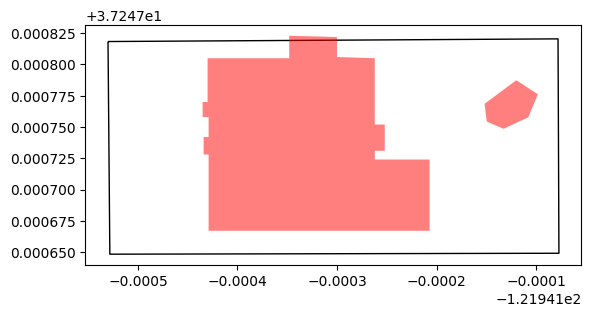

In [105]:
fig, ax = plt.subplots()
parcel_bounds.plot(ax=ax, facecolor='none', edgecolor='black')
ib_2016_parcel.plot(ax=ax, color='red', alpha=0.5)

#osm_parcel.plot(ax=ax, color='blue', alpha=0.5)
#parcel_buildings.plot(ax=ax, facecolor='purple', alpha=0.5)
plt.show()

## Specific cases

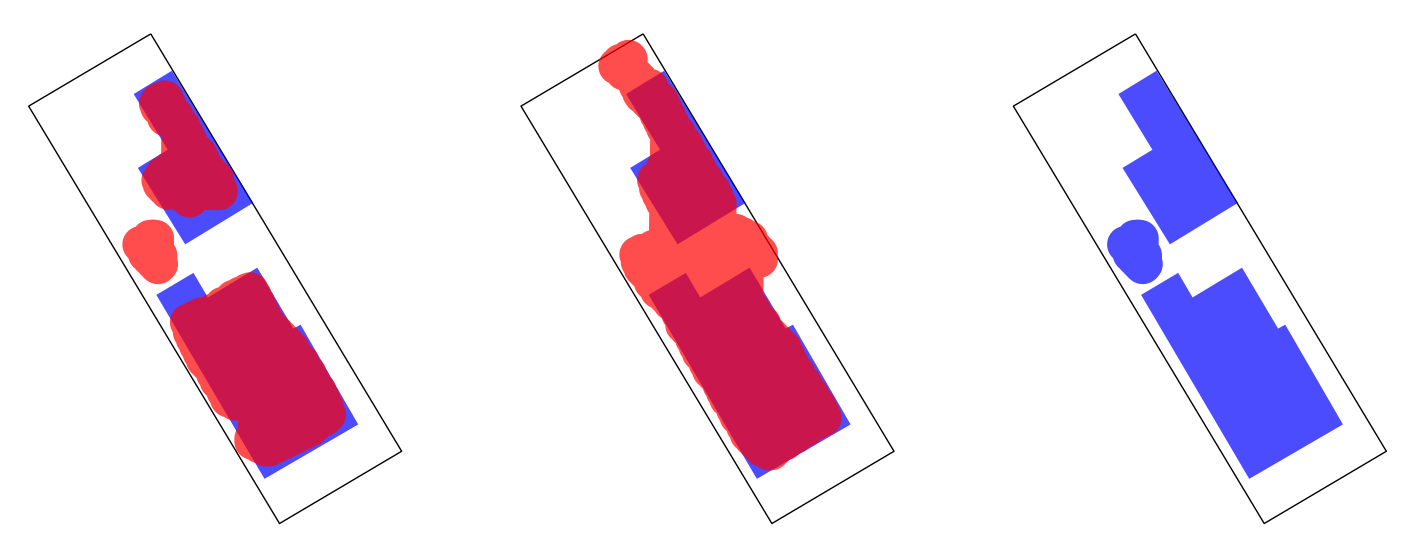

In [238]:
# Case: Yes OSM, yes inferences
parcel_build = run_osm_apn(parcel_apn='48114037', area_threshold=30, flatten_threshold=0.85)

In [14]:
parcel_build

main_building_flag  OSM_flag expansion_OSM_flag  expansion_2016_flag  \
0                True      True              False                False   
1               False      True              False                False   
2               False     False               None                False   

                                            geometry        area  
0  POLYGON ((-121.85854 37.34951, -121.85850 37.3...  153.613262  
1  POLYGON ((-121.85856 37.34961, -121.85853 37.3...   74.344571  
2  POLYGON ((-121.85857 37.34954, -121.85857 37.3...   19.658631

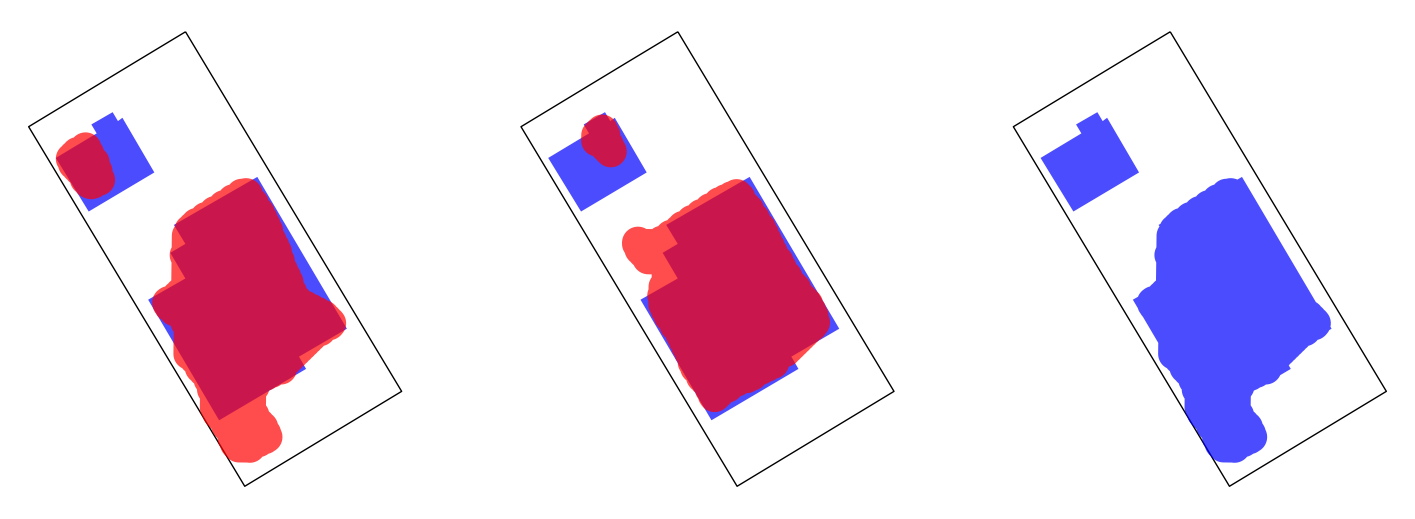

In [361]:
parcel_build = run_osm_apn(parcel_apn='48114039', area_threshold=30, flatten_threshold=0.85)

In [362]:
# Note main building is correctly flagged for an expansion
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
1               False      True               False                False   
2                True     False                True                 True   

                                            geometry        area  
1  POLYGON ((-121.85899 37.34946, -121.85894 37.3...   50.668790  
2  POLYGON ((-121.85888 37.34933, -121.85888 37.3...  313.645159

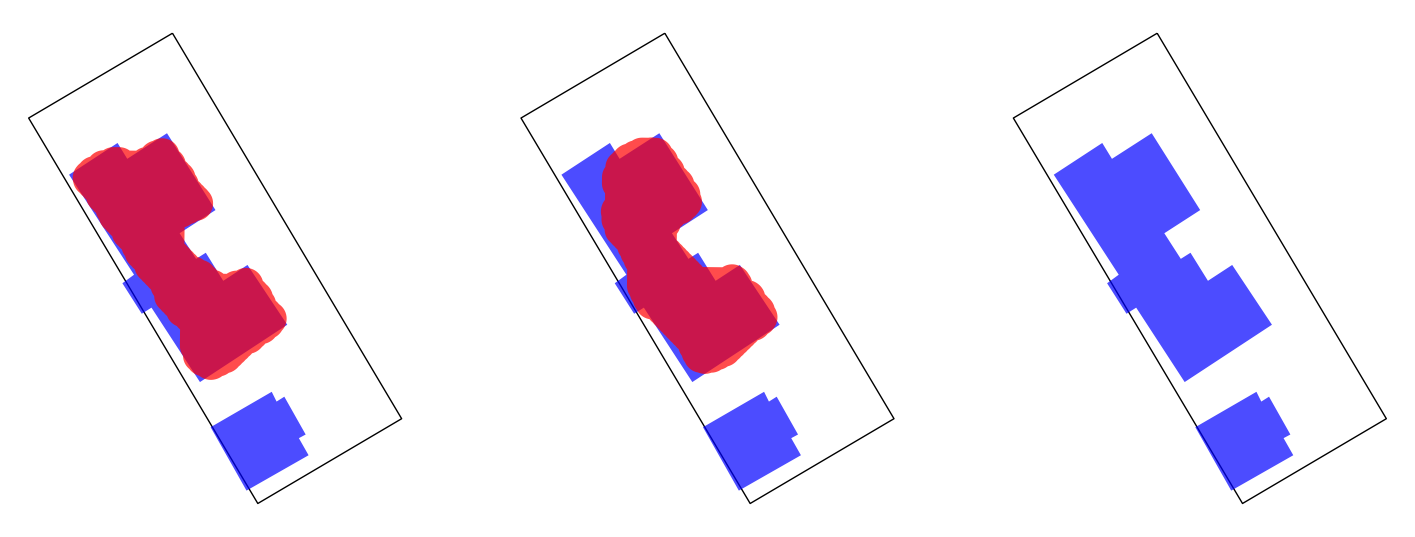

In [240]:
parcel_build = run_osm_apn(parcel_apn='48114071', area_threshold=30, flatten_threshold=0.85)

In [18]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag expansion_2016_flag  \
0               False      True               False               False   
1                True      True               False                None   

                                            geometry        area  
0  POLYGON ((-121.85806 37.34806, -121.85807 37.3...  189.828344  
1  POLYGON ((-121.85800 37.34796, -121.85793 37.3...   46.055422

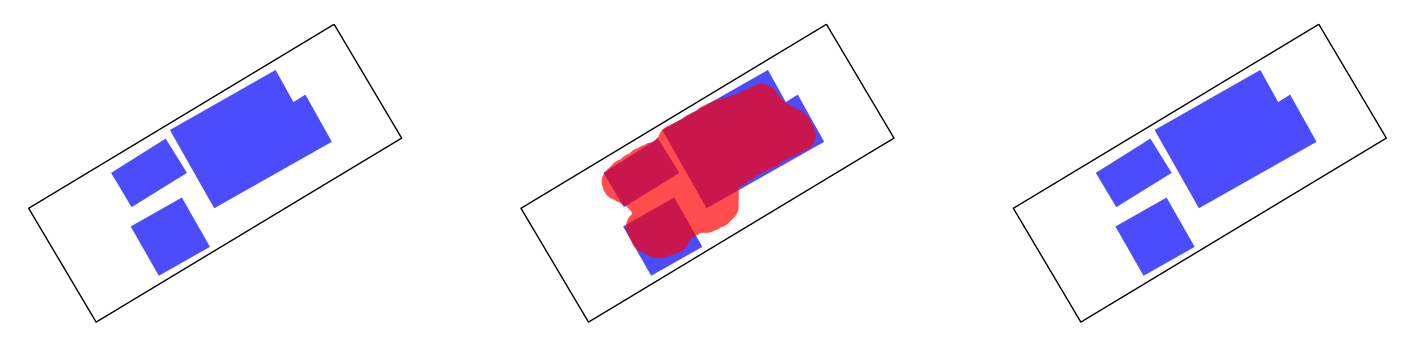

In [241]:
# Case: No inferences, yes OSM
parcel_build = run_osm_apn(parcel_apn='48147016', area_threshold=30, flatten_threshold=0.85)

In [21]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
2               False      True               False                False   
1               False      True               False                False   
0                True      True               False                False   

                                            geometry        area  
2  POLYGON ((-121.85541 37.34772, -121.85528 37.3...  125.616052  
1  POLYGON ((-121.85548 37.34768, -121.85541 37.3...   27.991134  
0  POLYGON ((-121.85540 37.34766, -121.85536 37.3...   35.883326

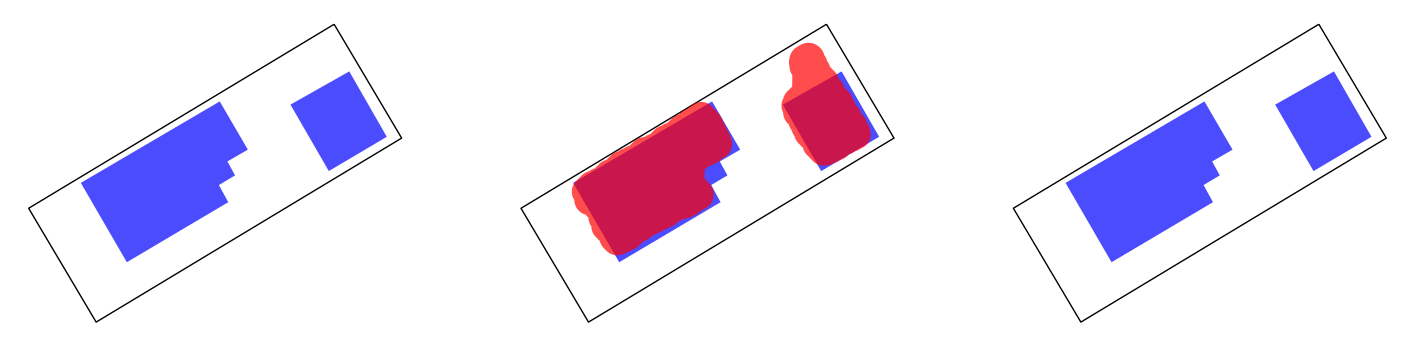

In [242]:
 parcel_build = run_osm_apn(parcel_apn='48147006', area_threshold=30, flatten_threshold=0.85)

# Note: we should ideally check protrusions for small buildings as well?
# In this case we actually have two small buildings, one not captured by OSM
# See google maps: 37.34749, -121.85587 

In [25]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                False   
1               False      True               False                False   

                                            geometry        area  
0  POLYGON ((-121.85587 37.34750, -121.85571 37.3...  145.297725  
1  POLYGON ((-121.85563 37.34758, -121.85556 37.3...   55.181344

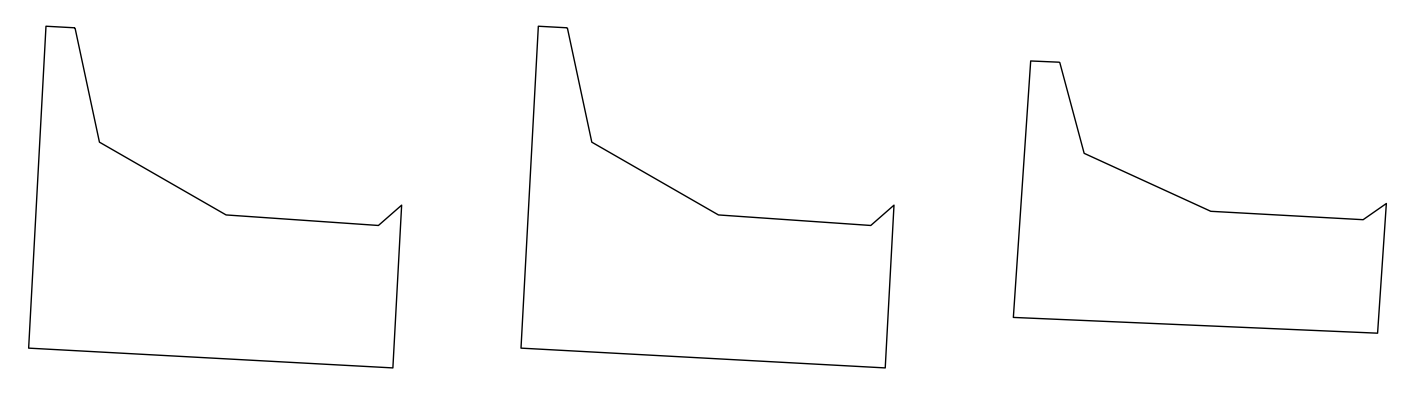

In [243]:
# Case: No OSM, no inferences  
parcel_build = run_osm_apn(parcel_apn='74209051', area_threshold=30, flatten_threshold=0.85)

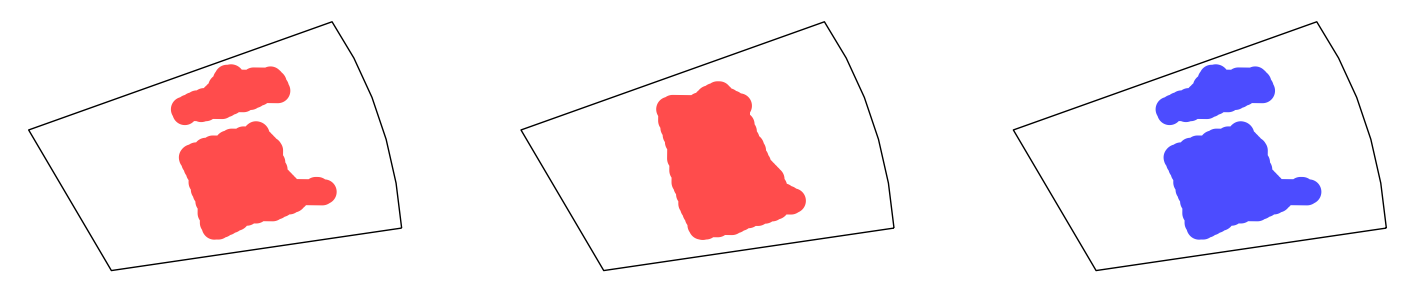

In [247]:
# Case: No OSM, yes inferences
parcel_build = run_osm_apn(parcel_apn='58708023', area_threshold=30, flatten_threshold=0.85)

In [248]:
parcel_build

main_building_flag  OSM_flag expansion_OSM_flag  expansion_2016_flag  \
0                True     False               None                False   
1               False     False               None                 True   

                                            geometry        area  
0  POLYGON ((-121.84690 37.40775, -121.84690 37.4...  173.497048  
1  POLYGON ((-121.84691 37.40780, -121.84691 37.4...   71.521142

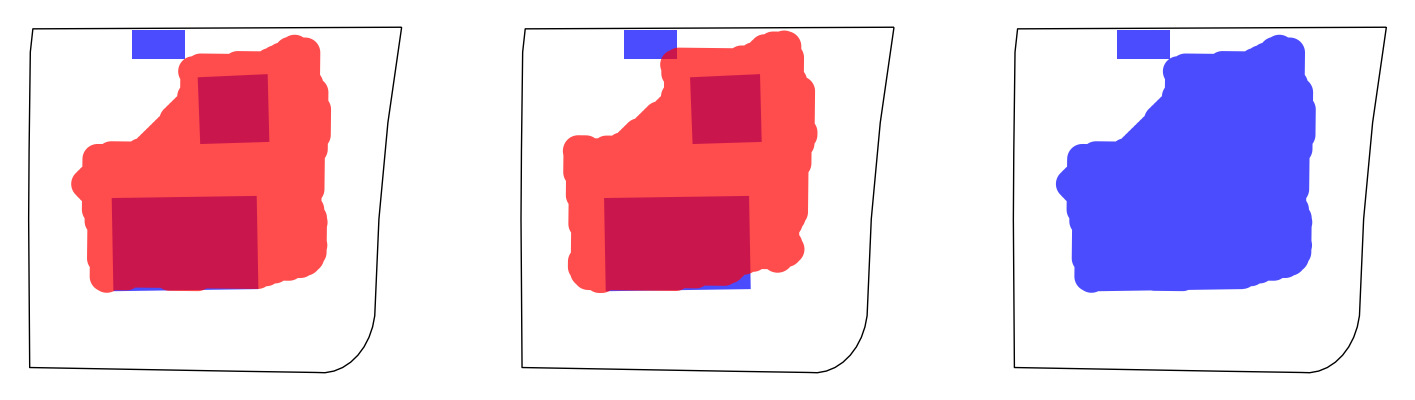

In [36]:
parcel_build = run_osm_apn(parcel_apn='41934035' , area_threshold=30, flatten_threshold=0.85 )

In [251]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
2               False      True               False                False   
3                True     False                True                False   

                                            geometry        area  
2  POLYGON ((-121.93047 37.24504, -121.93047 37.2...   17.359926  
3  POLYGON ((-121.93053 37.24491, -121.93054 37.2...  551.122391

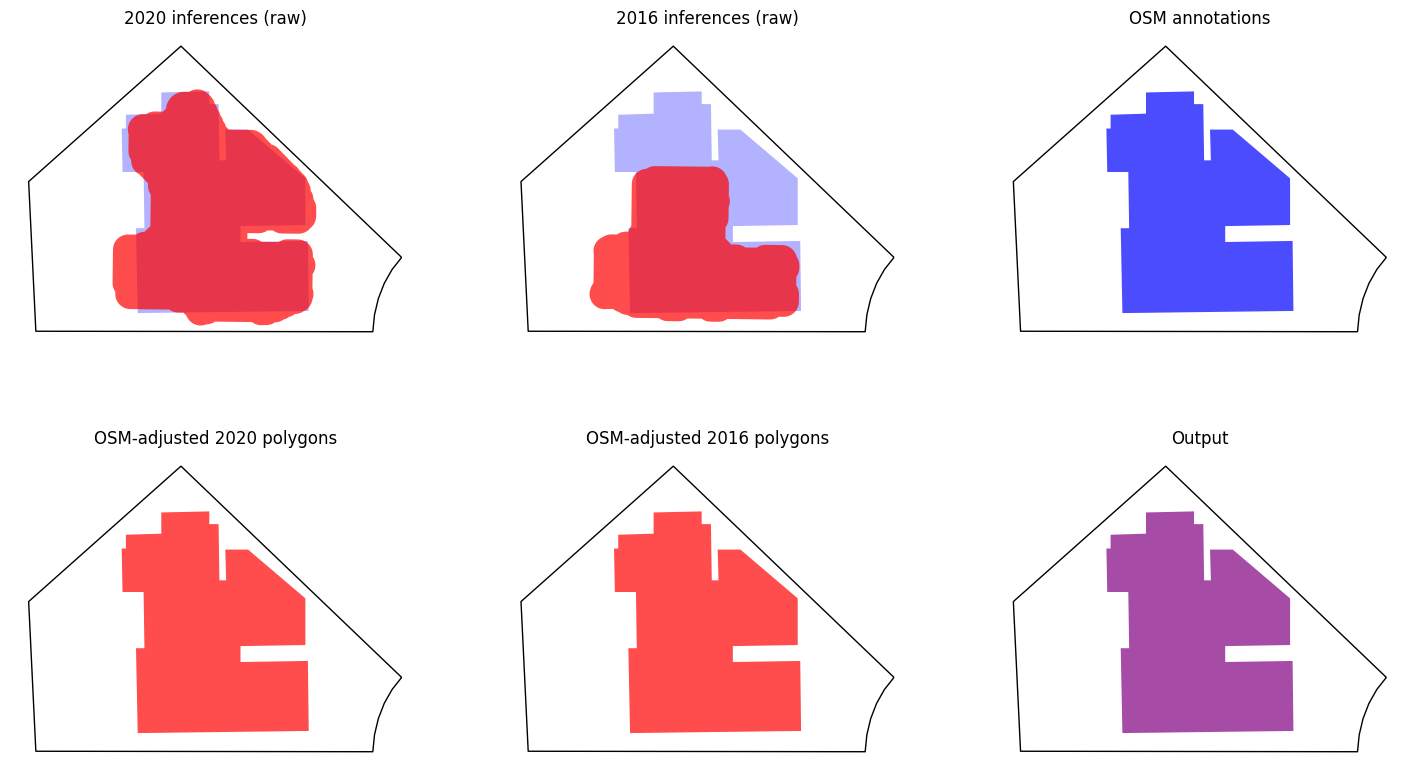

In [42]:
parcel_build = run_osm_apn_full_detail(parcel_apn='58630050', area_threshold=30, flatten_threshold=0.8)

In [257]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                 True   

                                            geometry        area  
0  POLYGON ((-121.86648 37.40674, -121.86649 37.4...  342.211339

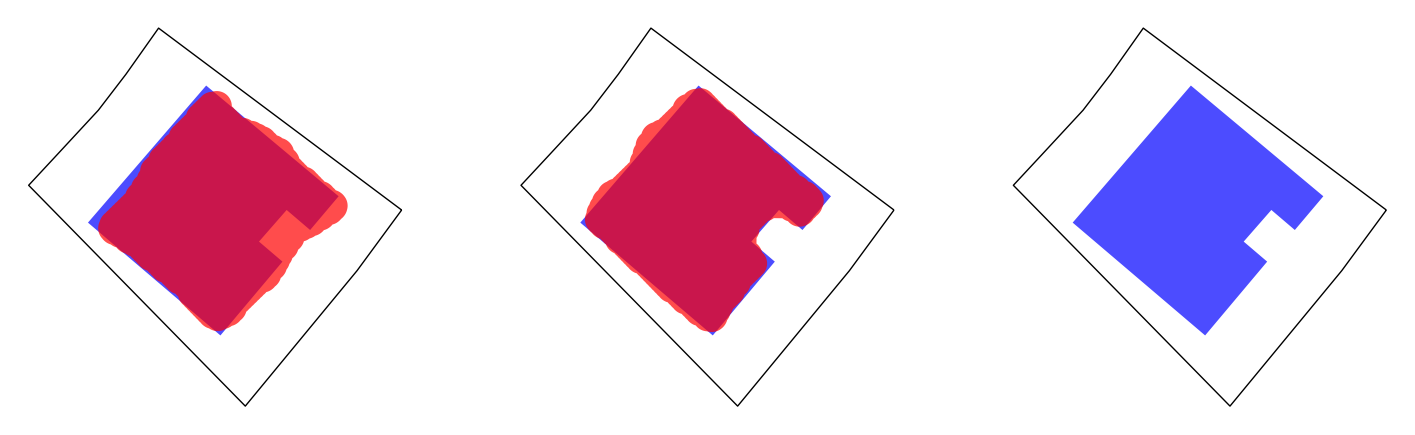

In [358]:
parcel_build = run_osm_apn(parcel_apn='65444028', area_threshold=40, flatten_threshold=0.80)

In [359]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                False   

                                            geometry        area  
0  POLYGON ((-121.77914 37.32825, -121.77900 37.3...  335.676245

In [269]:
apns = ['26114059', '23044043', '23018080', '26105030', 
        #'27461031','27461054',
        '27410003', '27415071', '27415152', '47230014']

26114059


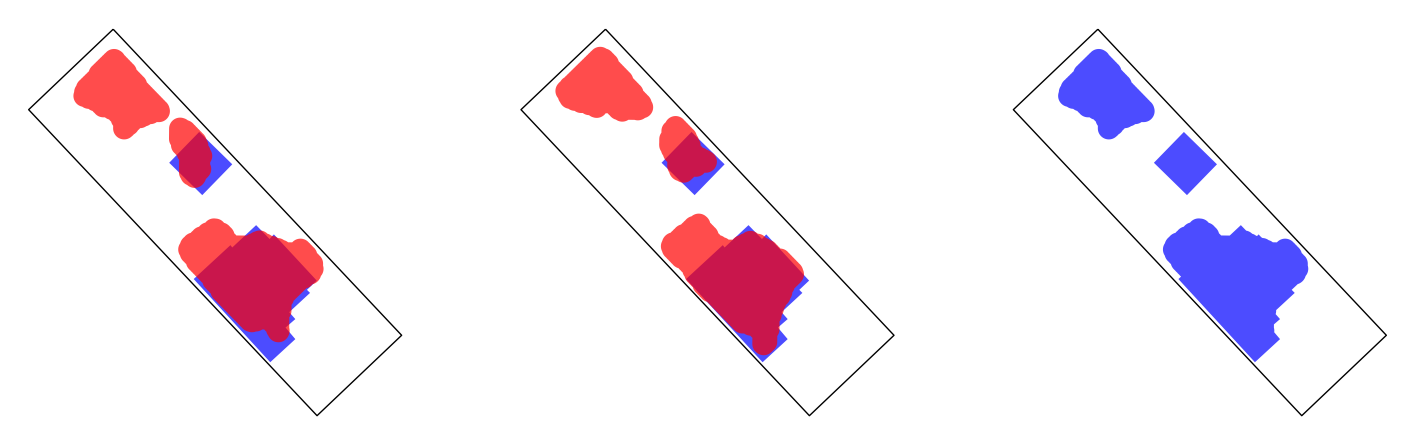

   main_building_flag  OSM_flag expansion_OSM_flag  expansion_2016_flag  \
1               False      True              False                False   
2                True     False               True                False   
3               False     False               None                False   

                                            geometry        area  
1  POLYGON ((-121.92336 37.33751, -121.92331 37.3...   41.460285  
2  POLYGON ((-121.92334 37.33739, -121.92334 37.3...  239.826937  
3  POLYGON ((-121.92351 37.33761, -121.92351 37.3...  102.062258  


23044043


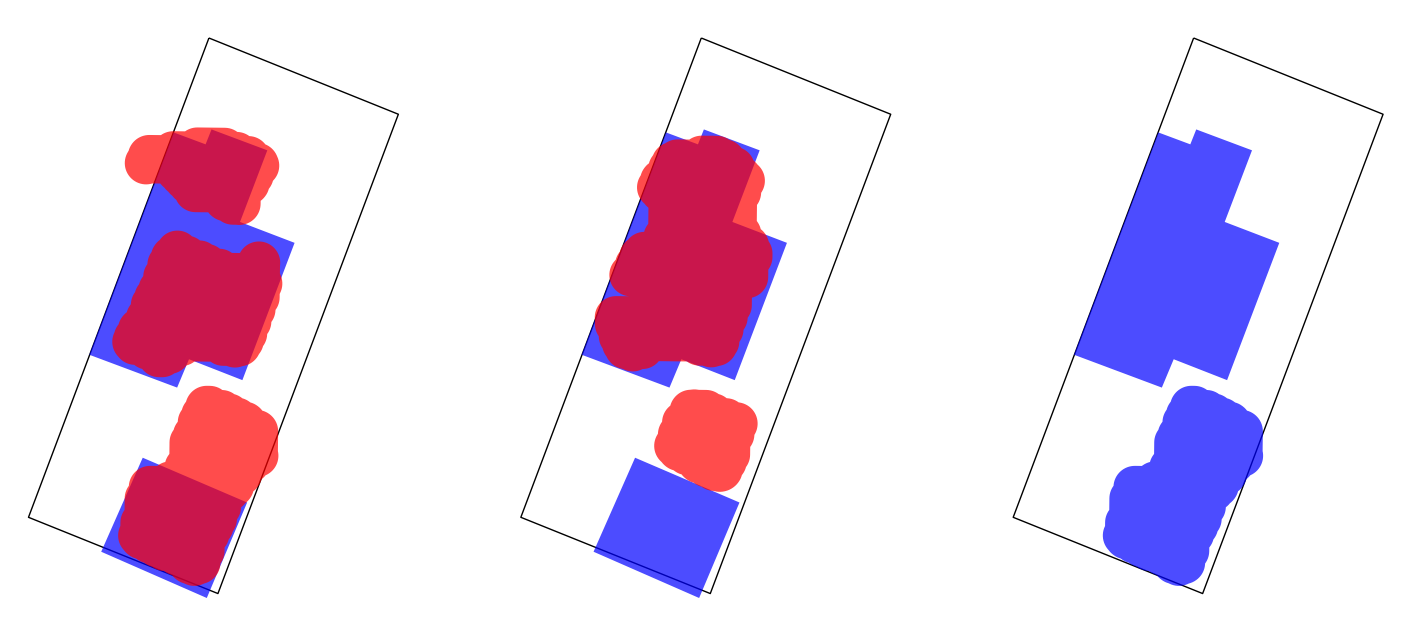

   main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0               False      True               False                False   
2               False     False                True                 True   

                                            geometry        area  
0  POLYGON ((-121.92701 37.34084, -121.92694 37.3...  176.807545  
2  POLYGON ((-121.92699 37.34073, -121.92699 37.3...  108.403114  


23018080


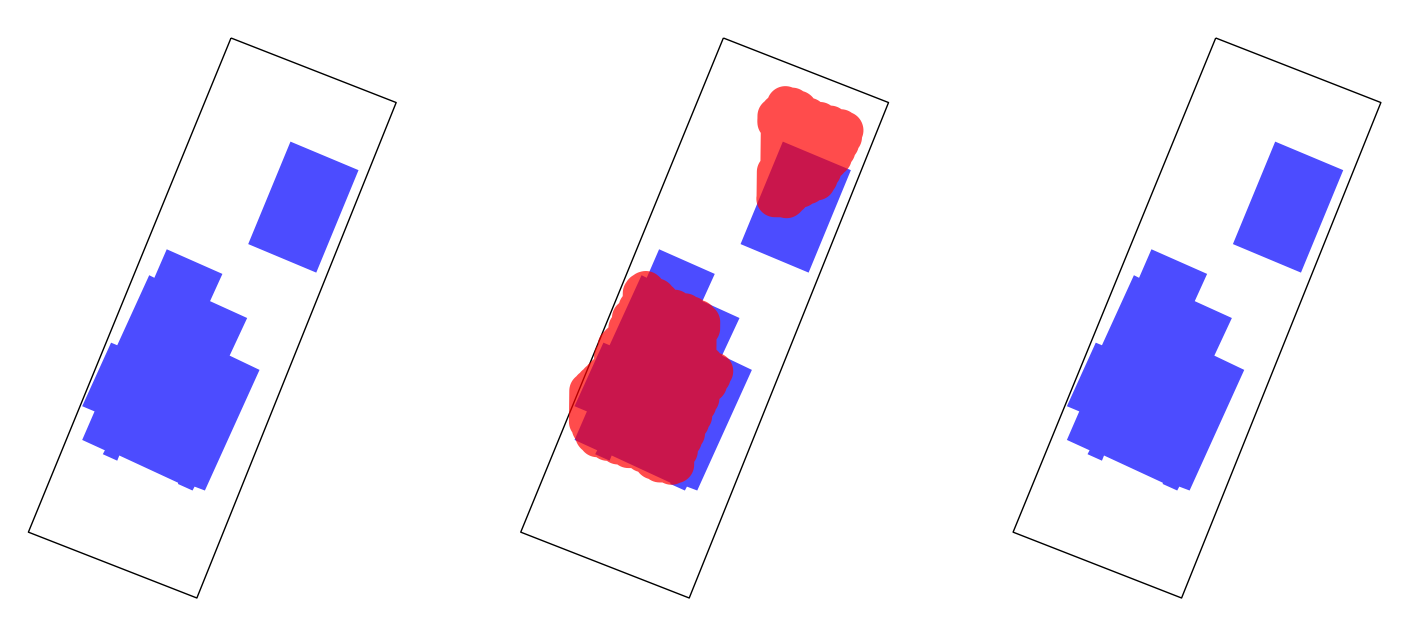

   main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
1               False      True               False                False   
0                True      True               False                False   

                                            geometry        area  
1  POLYGON ((-121.93151 37.34303, -121.93147 37.3...   60.111859  
0  POLYGON ((-121.93157 37.34285, -121.93157 37.3...  188.739358  


26105030


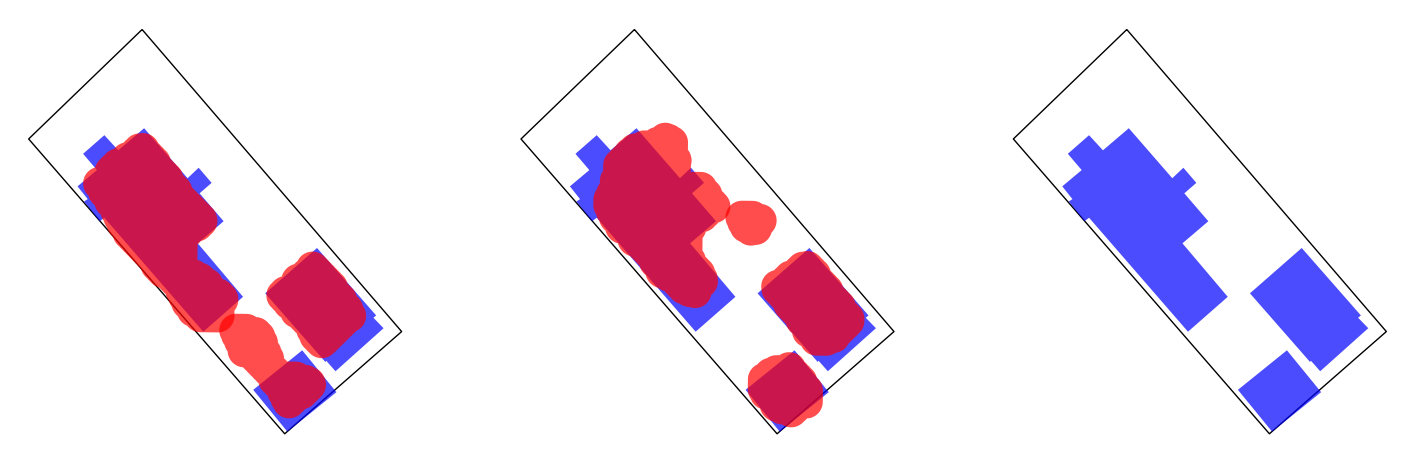

   main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
1               False      True               False                False   
2                True      True               False                 True   
0               False      True               False                False   

                                            geometry        area  
1  POLYGON ((-121.91126 37.33756, -121.91126 37.3...   65.213213  
2  POLYGON ((-121.91134 37.33753, -121.91129 37.3...   31.119936  
0  POLYGON ((-121.91150 37.33768, -121.91151 37.3...  142.319831  


27410003


KeyboardInterrupt: 

In [270]:
for parcel_apn in apns:
    print(parcel_apn)
    parcel_build = run_osm_apn(parcel_apn=parcel_apn, area_threshold=40, flatten_threshold=0.8)
    print(parcel_build.head())
    print('\n')

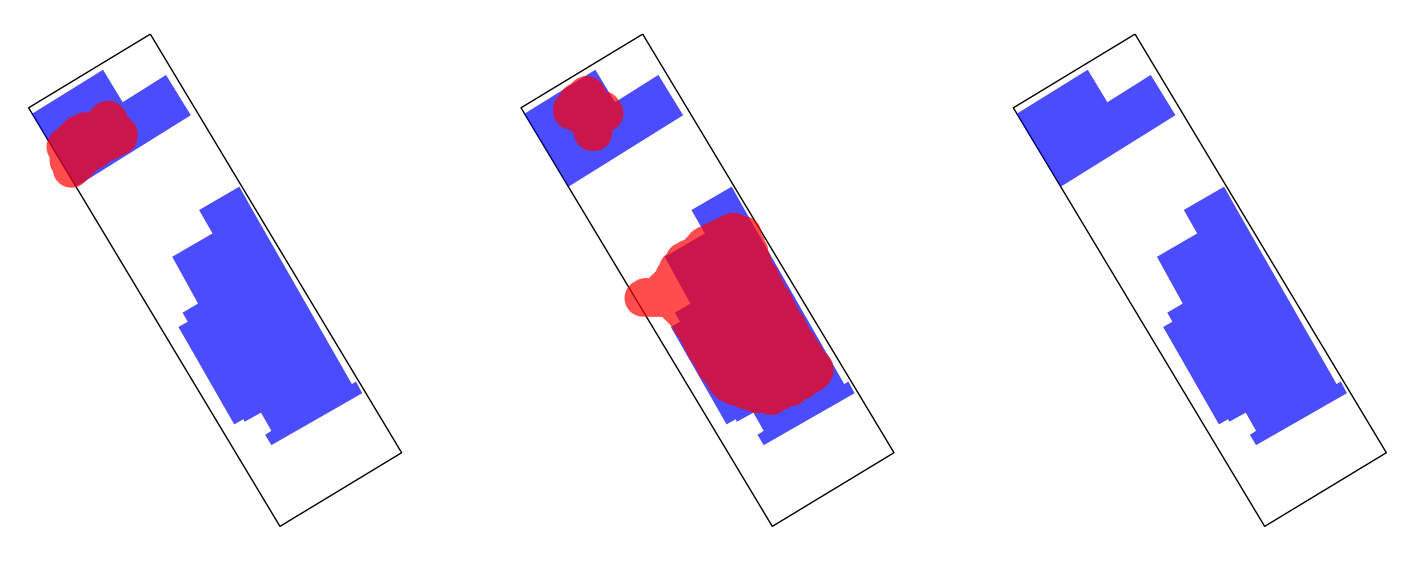

In [46]:
parcel_build = run_osm_apn('48115069', area_threshold=30)

In [47]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                False   
1               False      True               False                 True   

                                            geometry        area  
0  POLYGON ((-121.85586 37.35169, -121.85585 37.3...  181.446222  
1  POLYGON ((-121.85617 37.35190, -121.85610 37.3...   69.934630

# Parameter tuning and other pipeline explorations

## Compute IoU histogram for all parcels

In [20]:
inferred_buildings_2020_parcel.head()

GEOID        area  small  large  \
0  060855036021  148.727291      0      1   
1  060855036021   19.658631      1      0   
2  060855036021   61.113540      1      0   

                                            geometry  iou  
0  POLYGON ((-121.85852 37.34948, -121.85852 37.3...  1.0  
1  POLYGON ((-121.85857 37.34954, -121.85857 37.3...  1.0  
2  POLYGON ((-121.85855 37.34965, -121.85855 37.3...  1.0

In [104]:
def parcel_level_data_check(parcel_apn, sj_parcels_res, sj_parcel_permit):
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    def mask_buildings1(parcel_bounds, fp):
        df_out = gpd.read_file(fp, mask=parcel_bounds)
        df_out['iou'] = df_out['geometry'].intersection(parcel_bounds).area/df_out['geometry'].area
        df_out = df_out[df_out['iou'] > 0.1]
        if df_out.empty:
            return None
        else:
            return df_out

    inferred_buildings_2020_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2020'))
    inferred_buildings_2016_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], BUILD_FP.format('2016'))
    osm_buildings_parcel = mask_buildings1(parcel_bounds['geometry'].values[0], OSM_FP)

    permits_parcel = sj_parcel_permit[sj_parcel_permit['APN_parcel'] == parcel_apn]
    if permits_parcel.empty:
        permits_parcels = None

    return inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel

In [108]:
parcel_apns = sj_parcels_res['APN'].unique()

np.random.seed(42)
sample_parcel_apns = np.random.choice(parcel_apns, size=1000, replace=False)
ious = pd.DataFrame()
for parcel_apn in tqdm(sample_parcel_apns):
    inferred_buildings_2020_parcel, _, _, _ = parcel_level_data_check(parcel_apn, sj_parcels_res, sj_parcel_permit)
    if inferred_buildings_2020_parcel is not None:
        inferred_buildings_2020_parcel['parcel_apn'] = parcel_apn
        ious = pd.concat([ious, inferred_buildings_2020_parcel[['iou', 'parcel_apn']]])
        

100%|██████████| 1000/1000 [20:20<00:00,  1.22s/it]


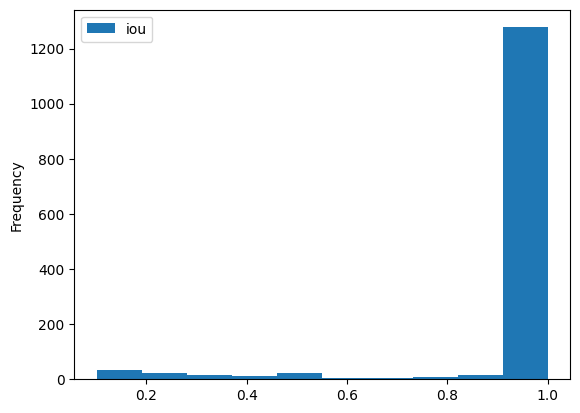

In [110]:
ious.plot.hist()
plt.show()

In [111]:
ious.sort_values('iou').head()

iou parcel_apn
0  0.101726   48152052
0  0.102216   27718063
0  0.102381   47743106
0  0.108706   67668003
1  0.111567   43920080

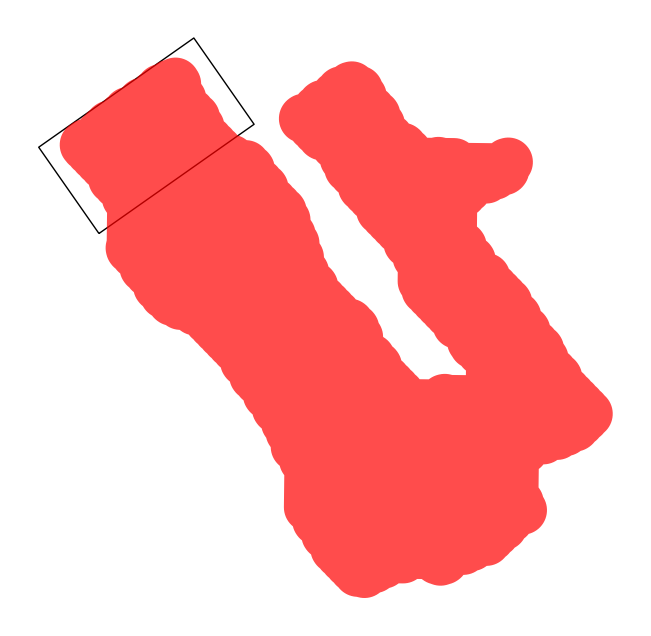

14078    POLYGON ((-121.85094 37.36005, -121.85082 37.3...
Name: geometry, dtype: geometry


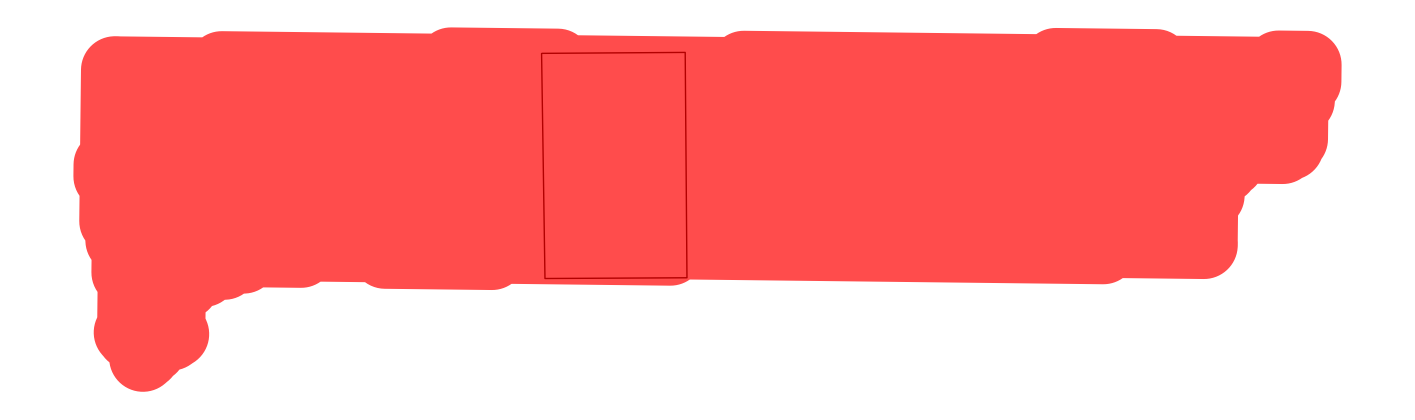

159075    POLYGON ((-121.91866 37.32064, -121.91865 37.3...
Name: geometry, dtype: geometry


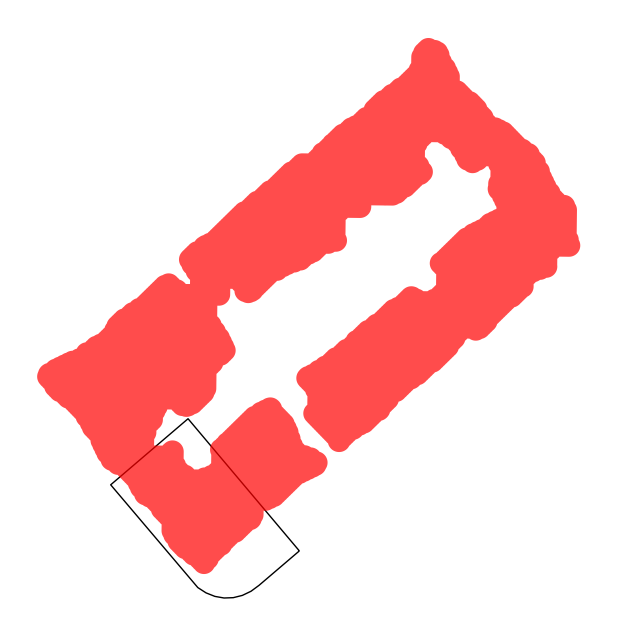

2513    POLYGON ((-121.83781 37.32304, -121.83796 37.3...
Name: geometry, dtype: geometry


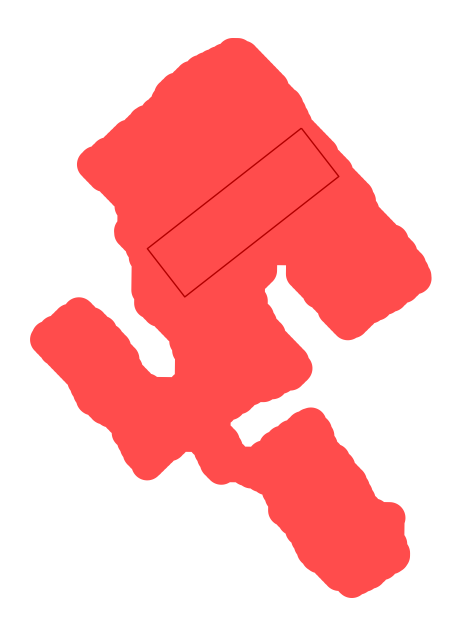

75153    POLYGON ((-121.80894 37.30445, -121.80912 37.3...
Name: geometry, dtype: geometry


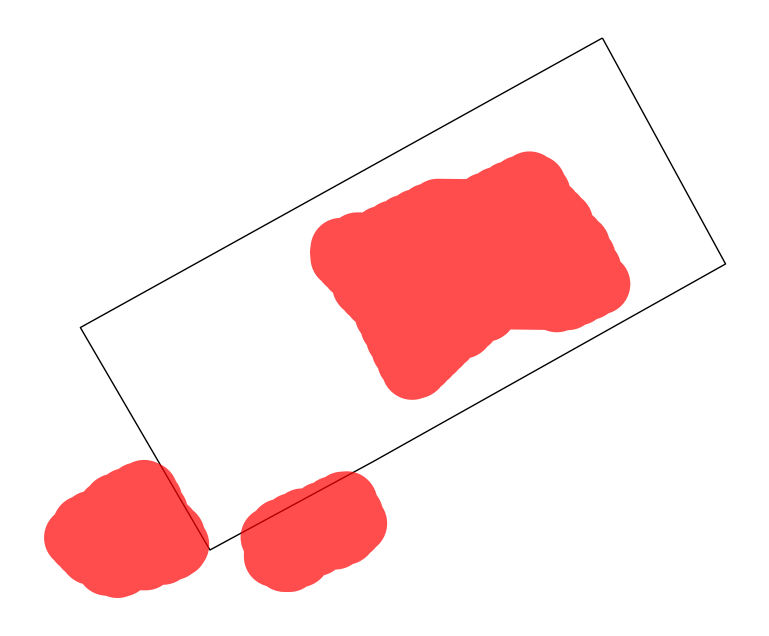

47163    POLYGON ((-121.88798 37.30008, -121.88829 37.2...
Name: geometry, dtype: geometry


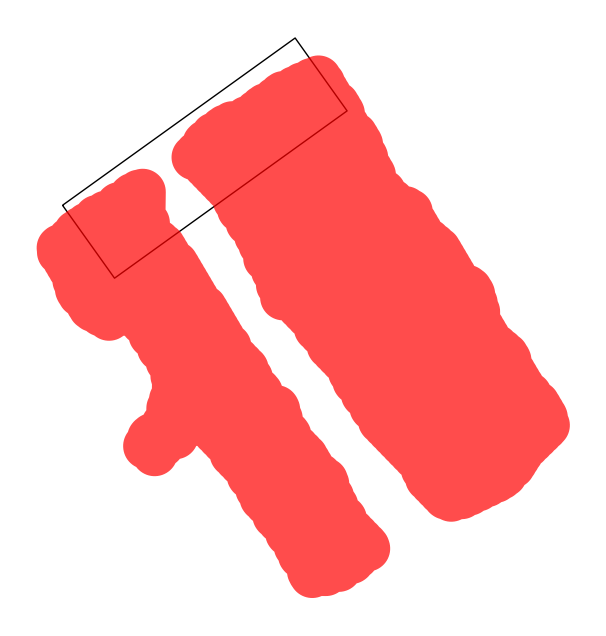

76959    POLYGON ((-121.81096 37.30479, -121.81092 37.3...
Name: geometry, dtype: geometry


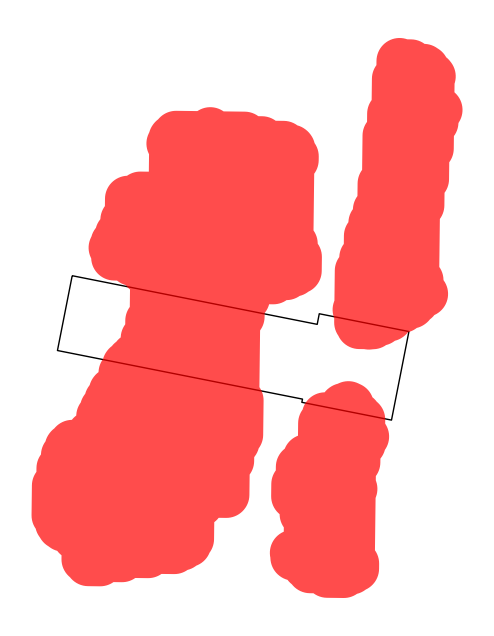

30351    POLYGON ((-121.86054 37.37717, -121.86055 37.3...
Name: geometry, dtype: geometry


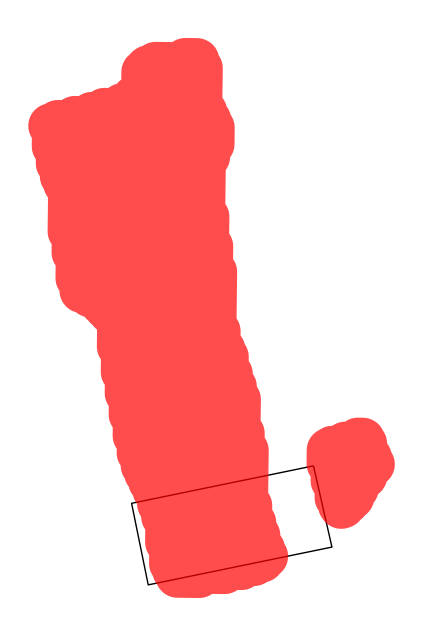

117235    POLYGON ((-121.82049 37.25658, -121.82064 37.2...
Name: geometry, dtype: geometry


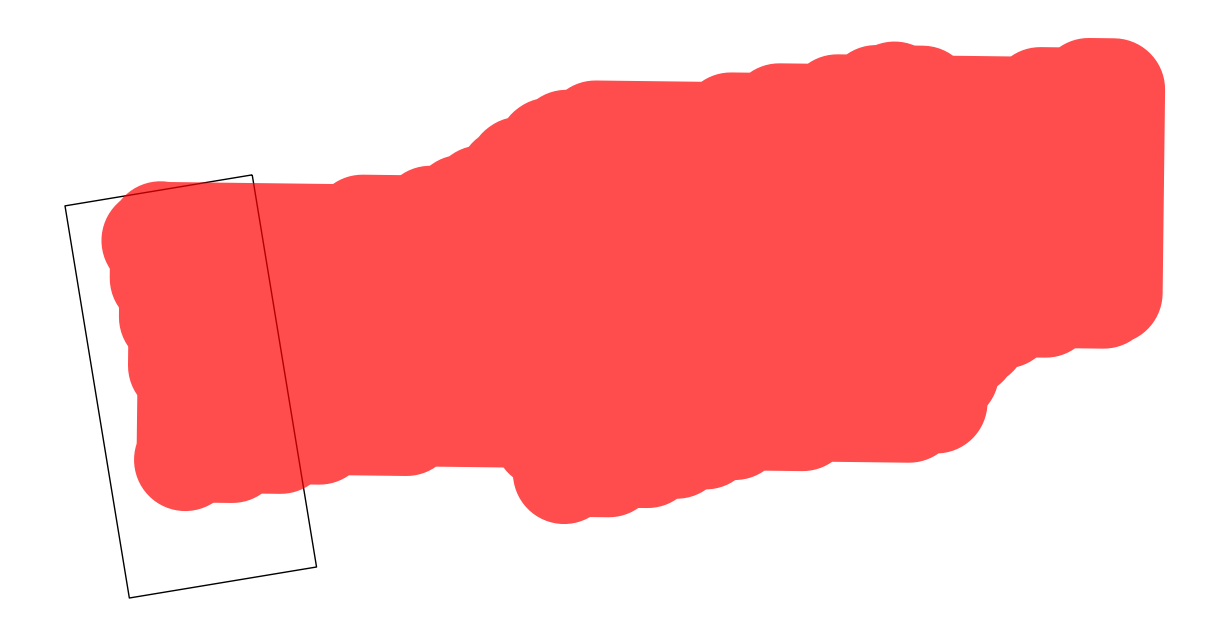

11133    POLYGON ((-121.85351 37.36077, -121.85357 37.3...
Name: geometry, dtype: geometry


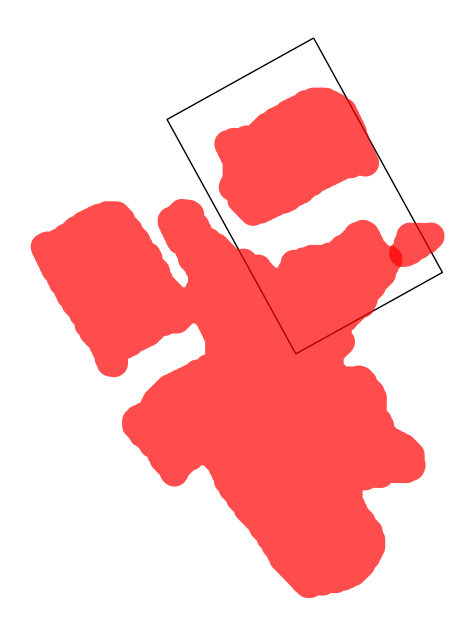

51861    POLYGON ((-121.91817 37.26133, -121.91836 37.2...
Name: geometry, dtype: geometry


In [157]:
# Look at parcels with poor IoU
for parcel_apn in ious.sort_values('iou').head(10)['parcel_apn'].unique():

    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    infer = gpd.read_file(BUILD_FP.format('2020'), mask=parcel_bounds)

    fig, (ax1) = plt.subplots(ncols=1, figsize=(18, 8))
    parcel_bounds.plot(ax=ax1, edgecolor='black', facecolor='none')

    if infer is not None:
        infer.plot(ax=ax1, color='red', alpha=0.7)
    ax1.axis('off')
    plt.show()
    print(parcel_bounds['geometry'])

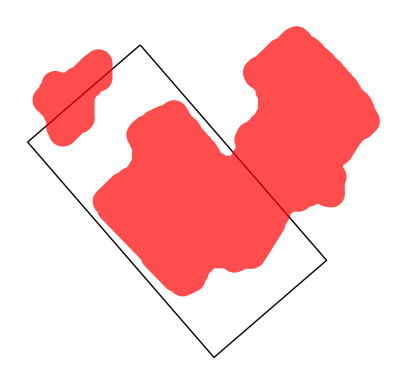

78918    POLYGON ((-121.80999 37.30162, -121.81014 37.3...
Name: geometry, dtype: geometry


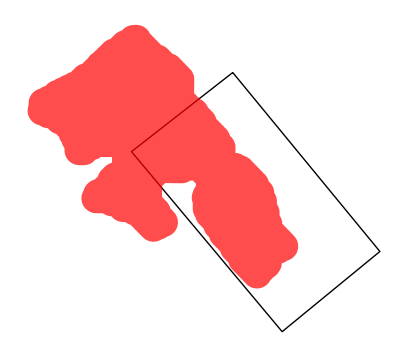

31590    POLYGON ((-121.88285 37.32254, -121.88297 37.3...
Name: geometry, dtype: geometry


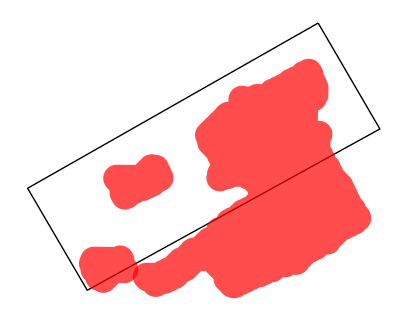

20088    POLYGON ((-121.88347 37.34905, -121.88385 37.3...
Name: geometry, dtype: geometry


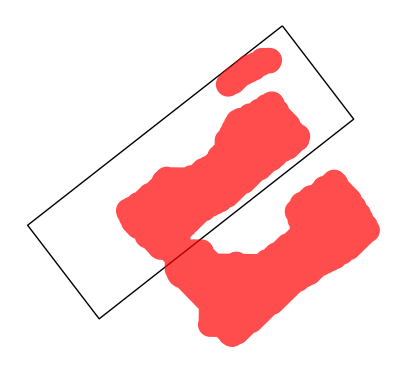

131306    POLYGON ((-121.86079 37.35425, -121.86116 37.3...
Name: geometry, dtype: geometry


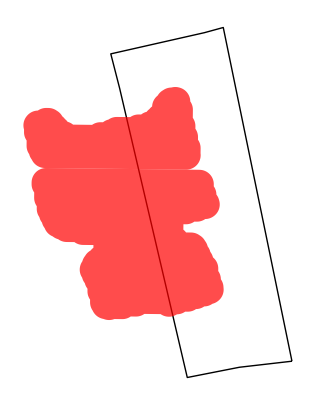

107080    POLYGON ((-121.91127 37.24364, -121.91136 37.2...
Name: geometry, dtype: geometry


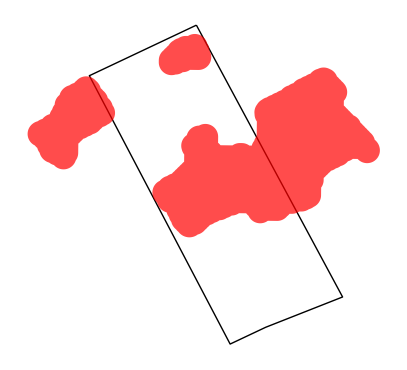

44100    POLYGON ((-121.89266 37.29471, -121.89281 37.2...
Name: geometry, dtype: geometry


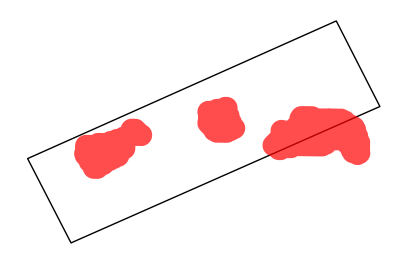

170182    POLYGON ((-121.89941 37.31338, -121.89947 37.3...
Name: geometry, dtype: geometry


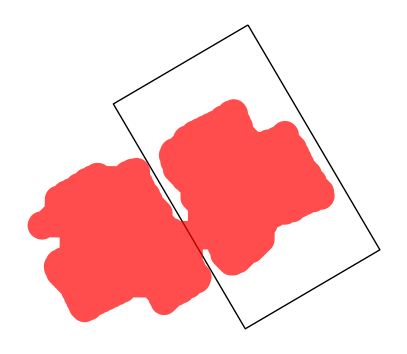

4417    POLYGON ((-121.87047 37.40748, -121.87065 37.4...
Name: geometry, dtype: geometry


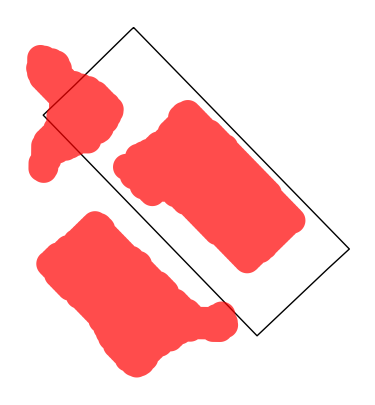

44163    POLYGON ((-121.91643 37.32643, -121.91643 37.3...
Name: geometry, dtype: geometry


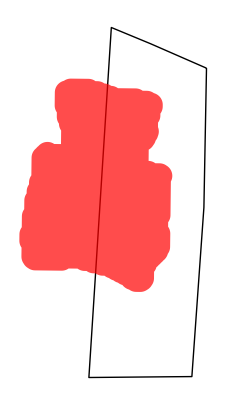

112413    POLYGON ((-121.90999 37.24258, -121.91008 37.2...
Name: geometry, dtype: geometry


In [159]:
# Look at parcels with poor IoU
iou_mid = ious.loc[ious['iou'] > 0.4].sort_values('iou').head(10)
for parcel_apn in iou_mid['parcel_apn'].unique():

    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

    infer = gpd.read_file(BUILD_FP.format('2020'), mask=parcel_bounds)

    fig, (ax1) = plt.subplots(ncols=1, figsize=(5, 5))
    parcel_bounds.plot(ax=ax1, edgecolor='black', facecolor='none')

    if infer is not None:
        infer.plot(ax=ax1, color='red', alpha=0.7)
    ax1.axis('off')
    plt.show()
    print(parcel_bounds['geometry'])

## Histogram of parcel sizes

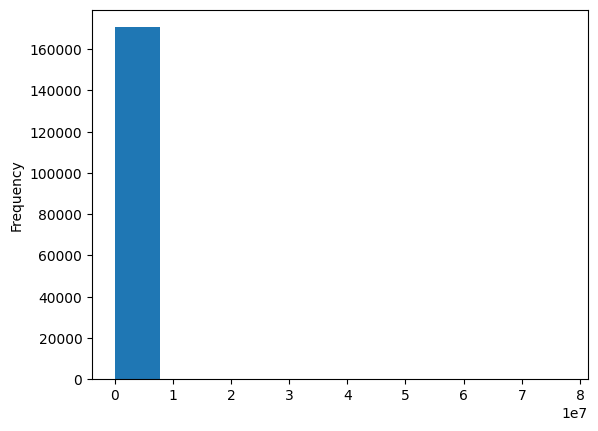

In [16]:
sj_parcels_res['SHAPE_Area'].plot.hist()
plt.show()

In [17]:
sj_parcels_res['SHAPE_Area'].describe()

count    1.706750e+05
mean     1.661177e+04
std      3.719040e+05
min      9.088756e-02
25%      5.905989e+03
50%      6.359288e+03
75%      7.758751e+03
max      7.751463e+07
Name: SHAPE_Area, dtype: float64

In [279]:
sj_parcels_res.sort_values('SHAPE_Area', ascending=False).head(1)

OBJECTID PARCELID   INTID       APN LOTNUM PARCELTYPE FEATURECLASS  \
84261    101605   126776  126776  66018004   None        Tax       Parcel   

      PLANCRT PLANMOD                 LASTUPDATE                      NOTES  \
84261     MGE    None  2022-05-24T22:13:09+00:00  Non-CSJ Parcel Correction   

      COVERED  SHAPE_Length    SHAPE_Area  \
84261    None   39017.56288  7.751463e+07   

                                                geometry  
84261  POLYGON ((-121.74388 37.30337, -121.74384 37.3...

## Histogram of number of buildings per parcel

In [8]:
parcel_apns = sj_parcels_res['APN'].unique()

np.random.seed(1)
sample_parcel_apns = np.random.choice(parcel_apns, size=1000, replace=False)
parcel_lens = []
for parcel_apn in tqdm(sample_parcel_apns):
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    
    # Incorporate OSM data
    parcel_diffs, _ = process_OSM_data(
        inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, 
        30, 0.85)
    parcel_lens.append(len(parcel_diffs))
        

100%|██████████| 1000/1000 [28:01<00:00,  1.68s/it] 


In [13]:
parcel_lens_hist = pd.DataFrame(parcel_lens, columns=['num_build'])

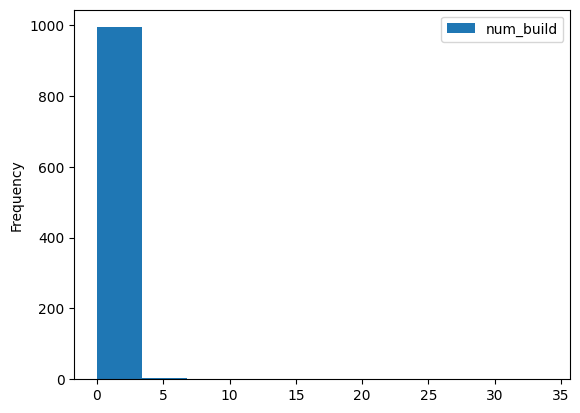

In [19]:
parcel_lens_hist.plot.hist()
plt.show()

In [17]:
parcel_lens_hist.describe()

num_build
count  1000.000000
mean      1.232000
std       1.417104
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max      34.000000

In [21]:
parcel_lens_hist.loc[parcel_lens_hist['num_build'] > 4]

num_build
54          34
239          5
326         24
526          6

## Histogram of building expansions
This is in order to tune the expansion threshold

In [39]:
parcel_apns = sj_parcels_res['APN'].unique()

np.random.seed(1)
sample_parcel_apns = np.random.choice(parcel_apns, size=3000, replace=False)

dif_gdf = pd.DataFrame()

for parcel_apn in tqdm(sample_parcel_apns):
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
    parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]
        
    # Incorporate OSM data
    parcel_build, _ = process_OSM_data(
        inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel,
        30, 0.85, parcel_bounds)
    parcel_build['apn'] = parcel_apn
    dif_gdf = pd.concat([dif_gdf, parcel_build[['apn', 'main_building_flag', 'diff_2016_value', 'diff_OSM_value']]])
       

100%|██████████| 3000/3000 [1:38:45<00:00,  1.98s/it]  


In [45]:
dif_gdf

apn main_building_flag diff_2016_value diff_OSM_value
0   58714081               True        7.627289      22.635869
0   45125039               True        4.231646            0.0
0   42108067               True        2.908823       2.908823
0   28412065               True       18.145075      16.904578
0   68938064               True             0.0       2.471897
..       ...                ...             ...            ...
0   69225033               True            None       3.542158
0   49713057               True        4.876443       4.888544
0   44704044               True             0.0              0
0   44216063               True       33.816541              0
0   38132007               True             0.0            0.0

[3509 rows x 4 columns]

In [46]:
dif_gdf.groupby('main_building_flag')[['diff_2016_value', 'diff_OSM_value']].describe()

diff_2016_value                      diff_OSM_value  \
                             count  unique  top    freq          count   
main_building_flag                                                       
False                        747.0   221.0  0.0   527.0          759.0   
True                        2604.0  1474.0  0.0  1131.0         2703.0   

                                         
                    unique  top    freq  
main_building_flag                       
False                  1.0  0.0   759.0  
True                1593.0  0.0  1111.0

In [47]:
dif_gdf['diff_2016_value'].median()

1.044979659407518

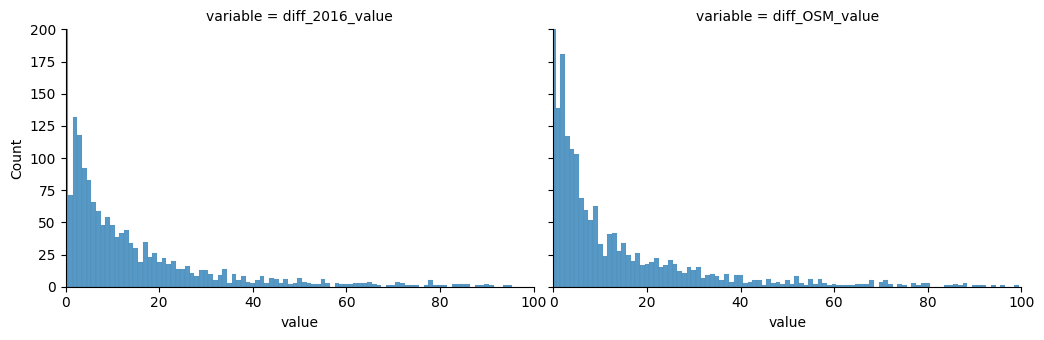

In [48]:
df = dif_gdf.loc[dif_gdf['main_building_flag'] == True][['diff_2016_value', 'diff_OSM_value']].melt()
g = sns.FacetGrid(df, col='variable', height=3.5, aspect=1.5)
g.map_dataframe(sns.histplot, 'value')

plt.xlim(0, 100)
plt.ylim(0, 200)
plt.show()

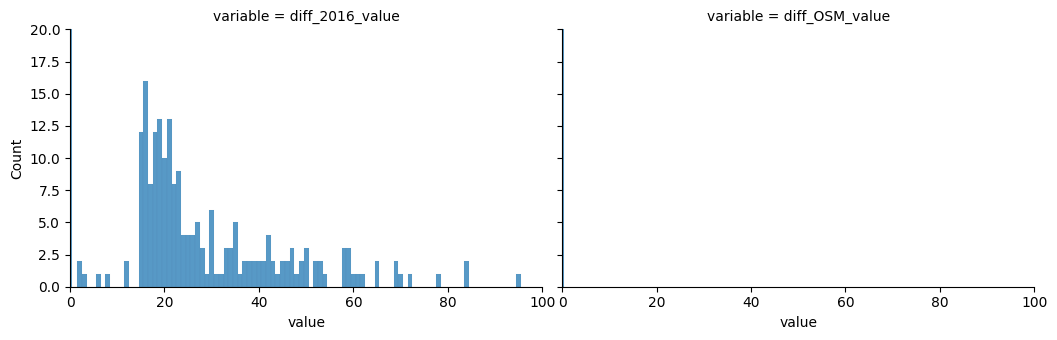

In [51]:
df = dif_gdf.loc[dif_gdf['main_building_flag'] == False][['diff_2016_value', 'diff_OSM_value']].melt()
g = sns.FacetGrid(df, col='variable', height=3.5, aspect=1.5)
g.map_dataframe(sns.histplot, 'value')

plt.xlim(0, 100)
plt.ylim(0, 20)
plt.show()

## Main building expansion check and small building construction

In [38]:
np.random.seed(2)
apns = sj_parcels_res['APN'].unique()
apns = np.random.choice(apns, 25, replace=False)

49936015


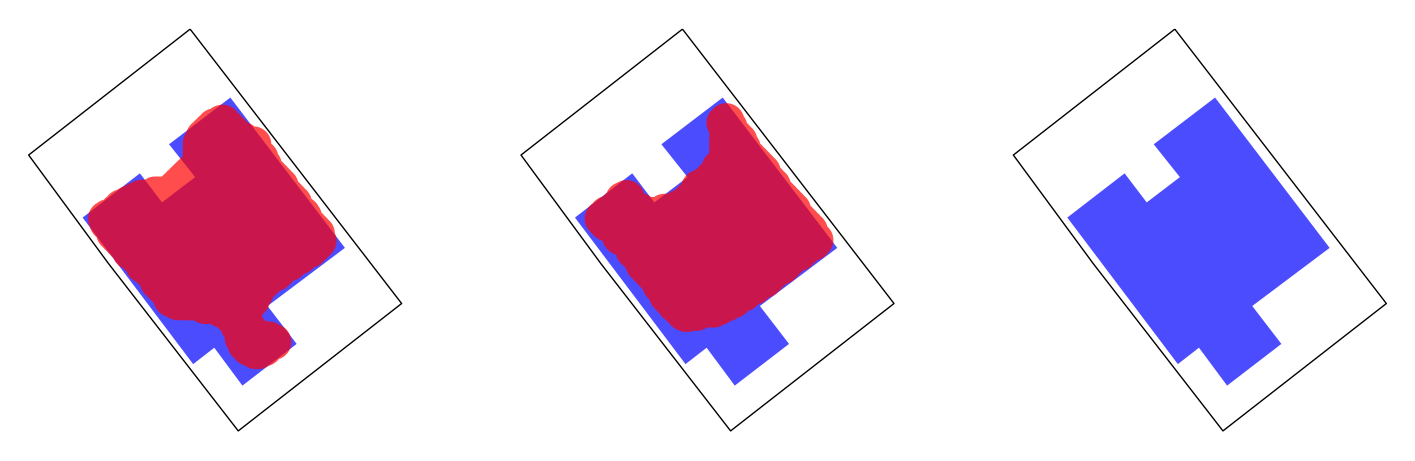

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  287.285781
[-121.82565200000002, 37.30202200000001]


70414030


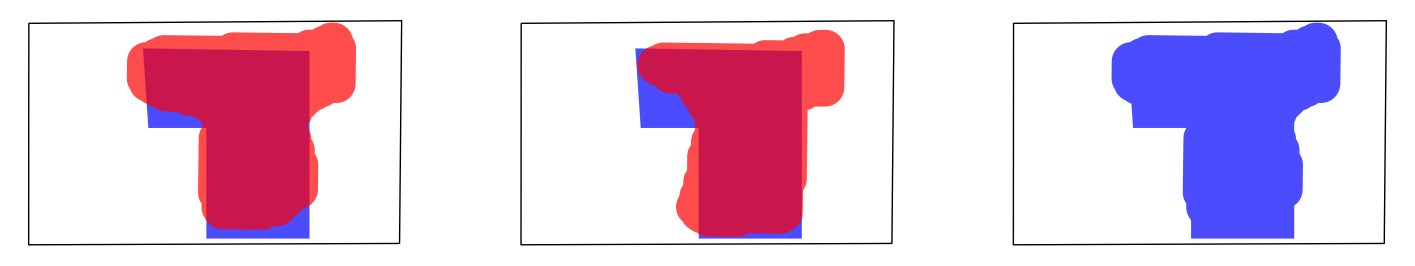

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
1                True     False          True          False  219.850817
[-121.79899599056449, 37.229369795365436]


68431104


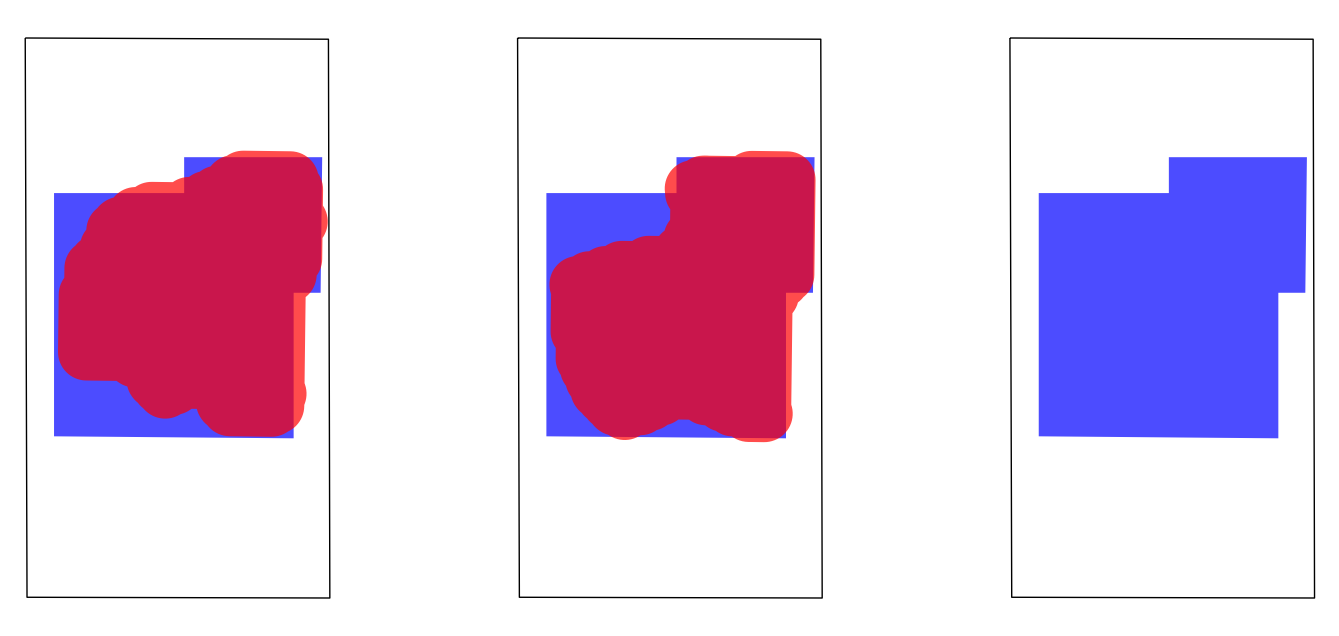

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  205.933408
[-121.80839, 37.26342900000001]


69517026


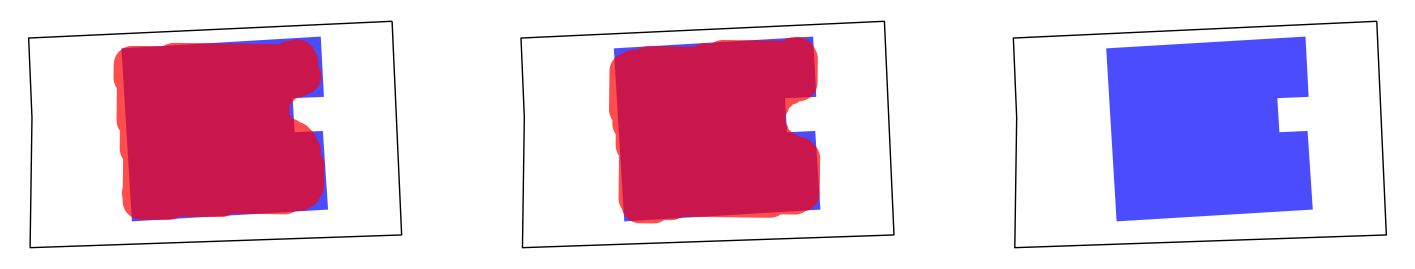

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  239.101537
[-121.842144, 37.23256899999999]


49127060


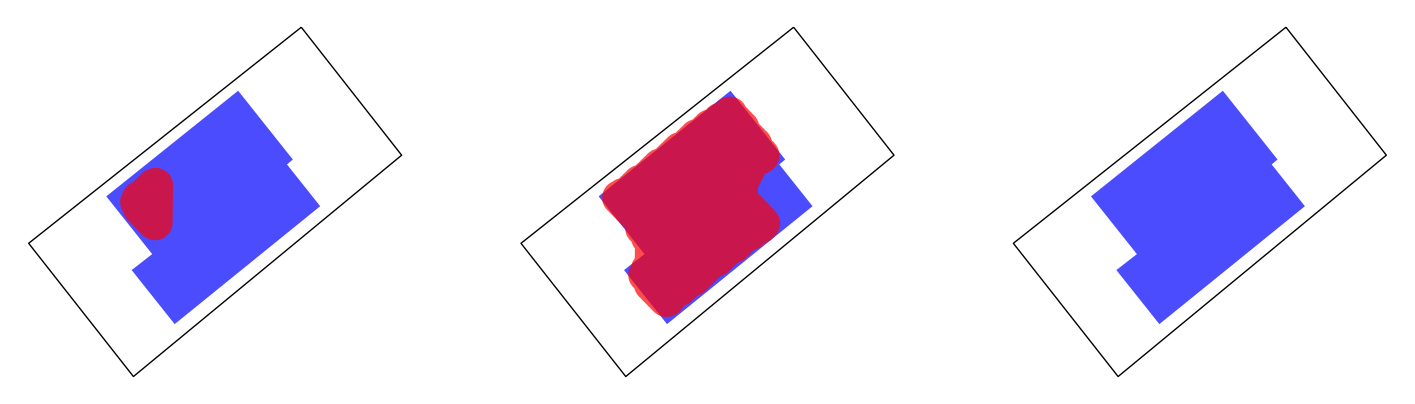

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  207.661634
[-121.83287999999999, 37.330887]


37315007


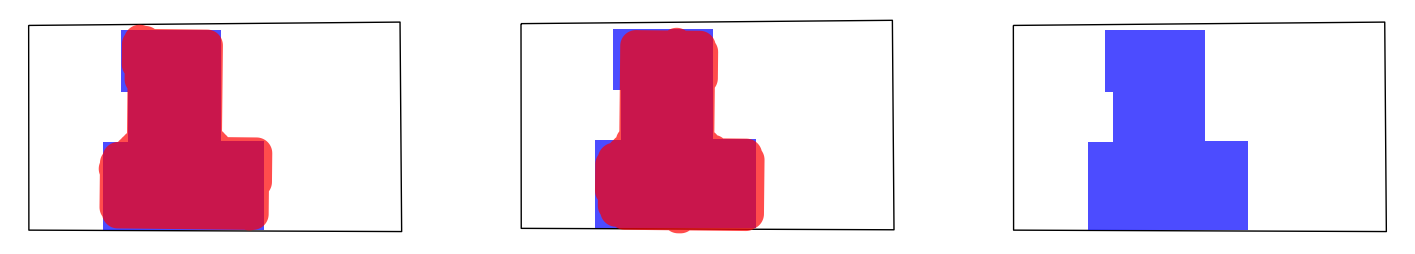

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag       area
0                True      True         False          False  253.69596
[-122.02042800000001, 37.298958000000006]


45115015


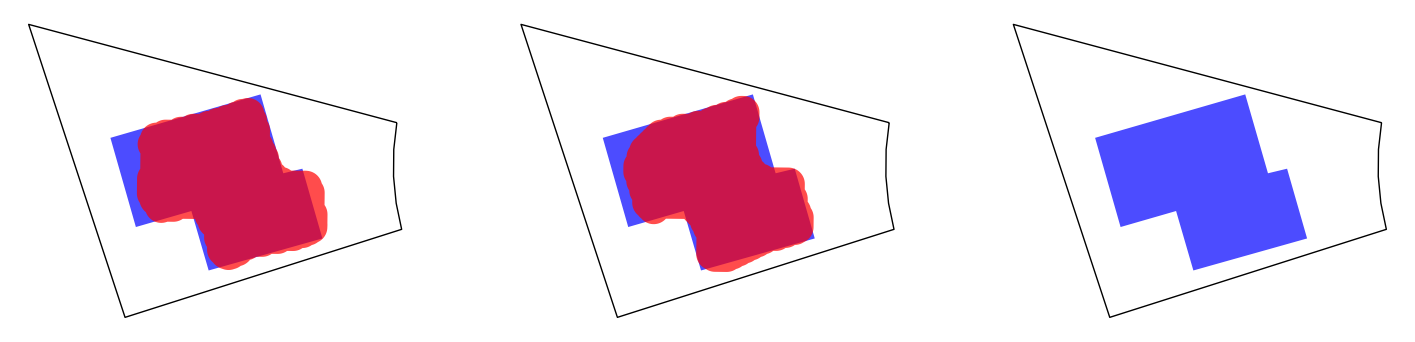

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  208.878152
[-121.894201, 37.27036199999999]


65444028


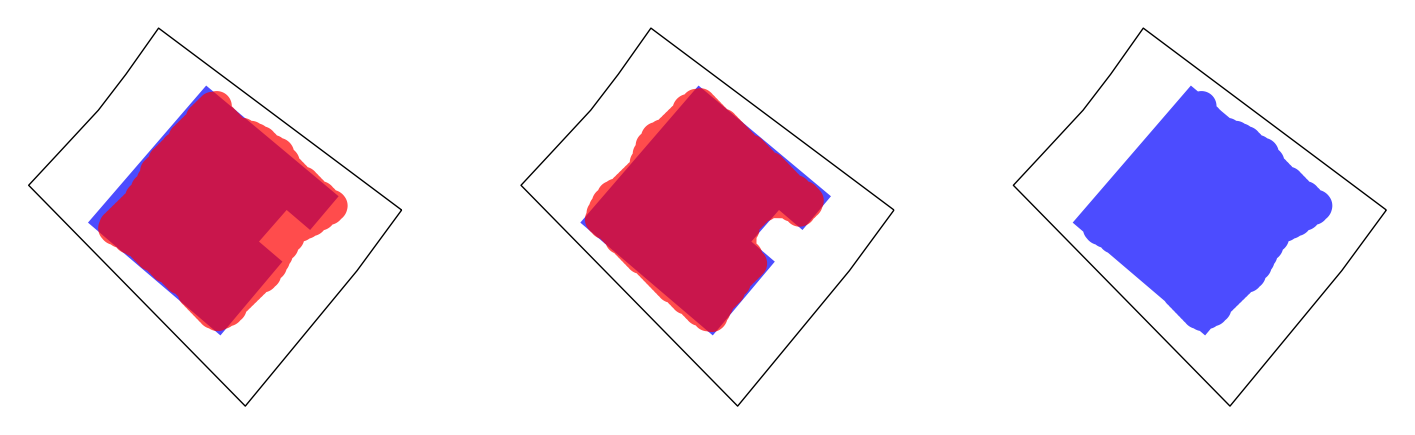

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
1                True     False          True           True  375.978525
[-121.77898952000285, 37.328376400875605]


67306036


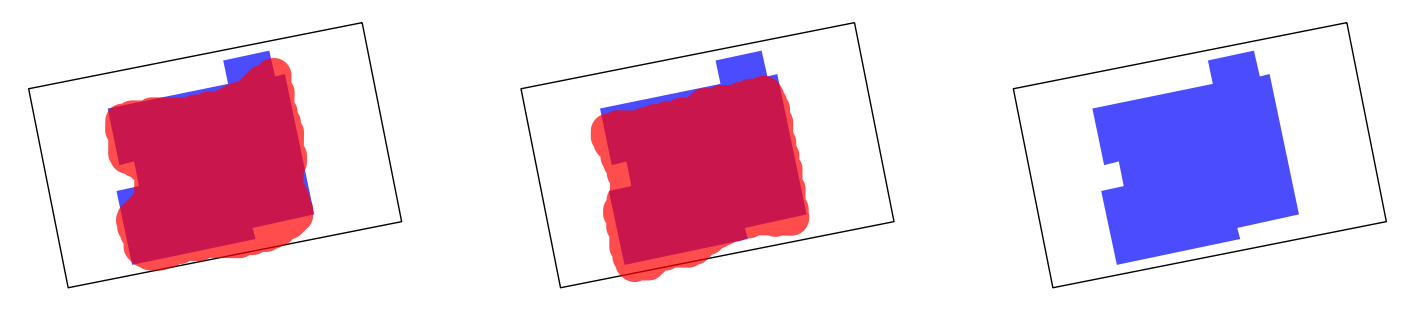

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  237.204676
[-121.79996400000002, 37.32507199999999]


41919045


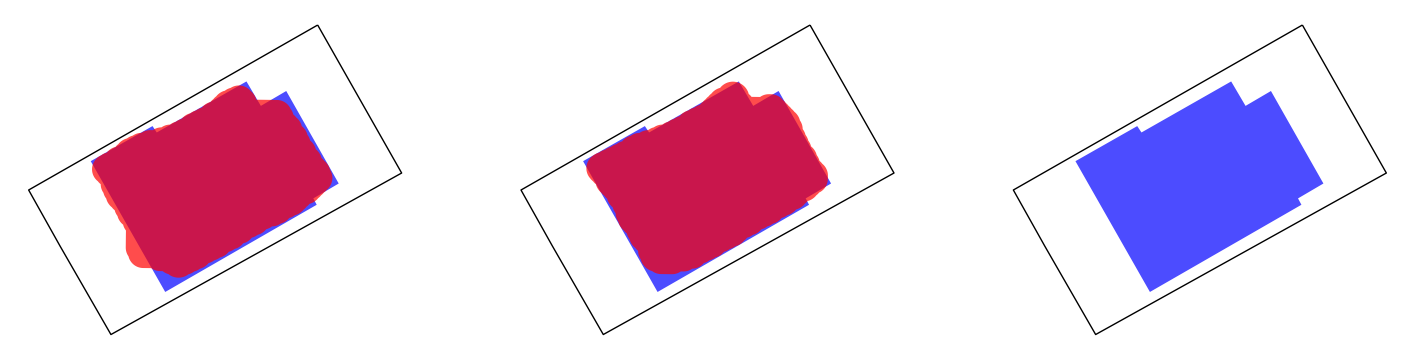

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  312.746272
[-121.91480200000001, 37.254743000000005]


45147015


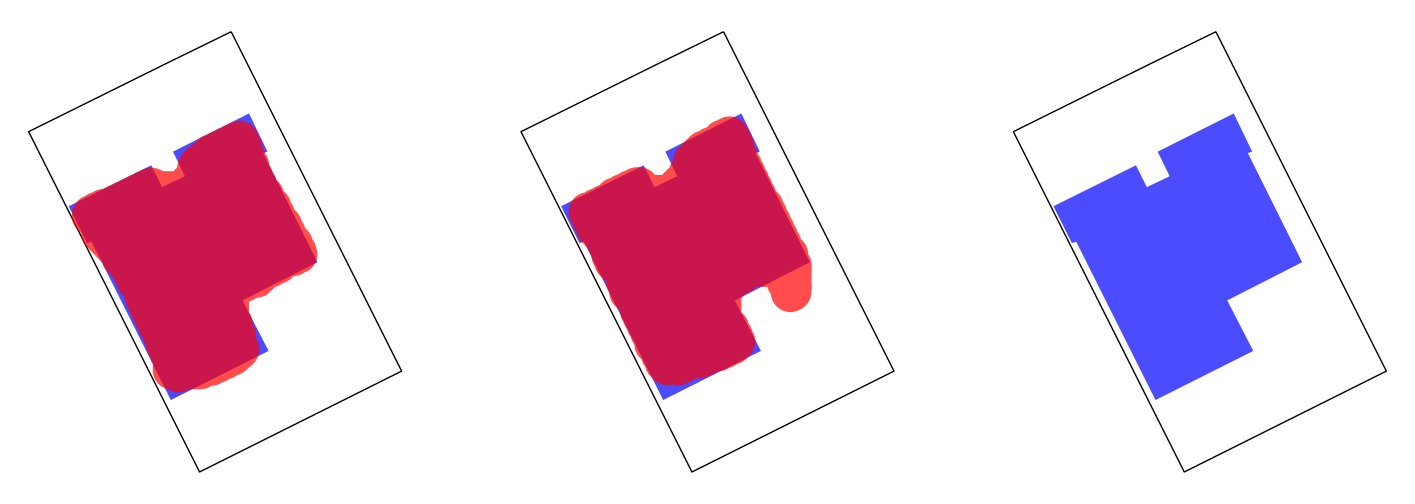

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag       area
0                True      True         False          False  248.05413
[-121.900713, 37.25784899999999]


44724015


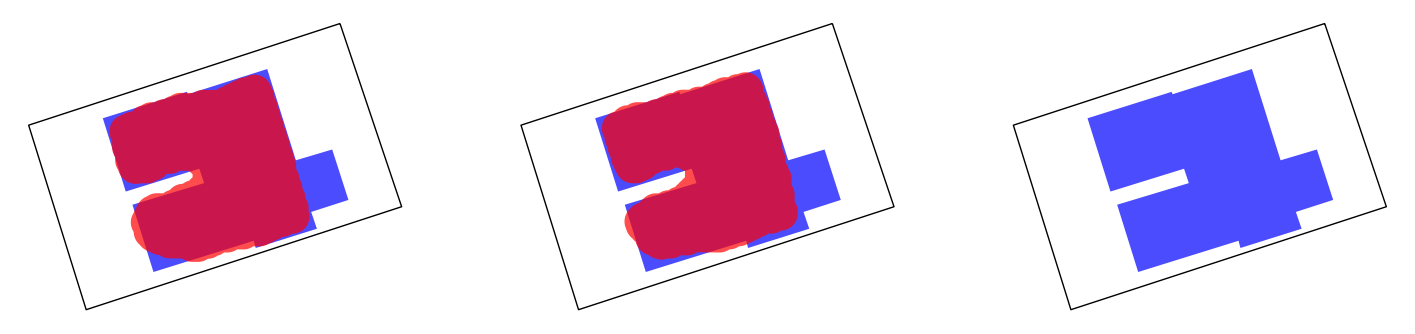

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  246.821626
[-121.89811799999998, 37.26632299999999]


57741012


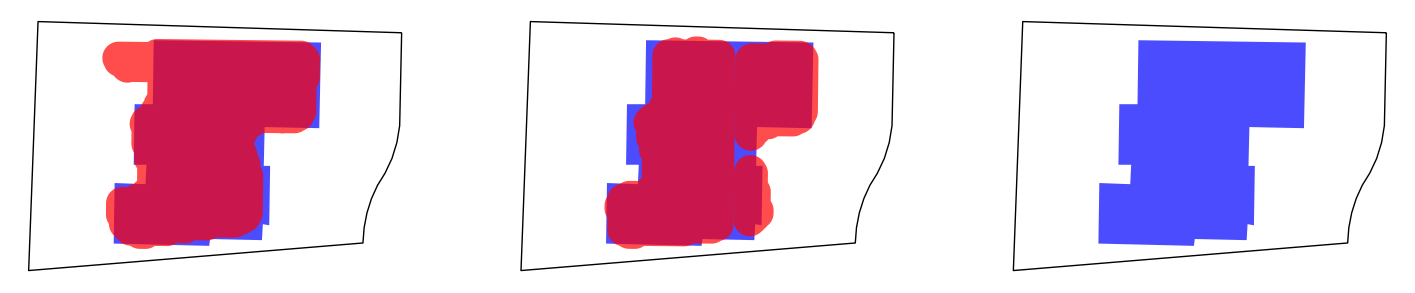

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  294.504457
[-121.887619, 37.233405000000005]


25442074


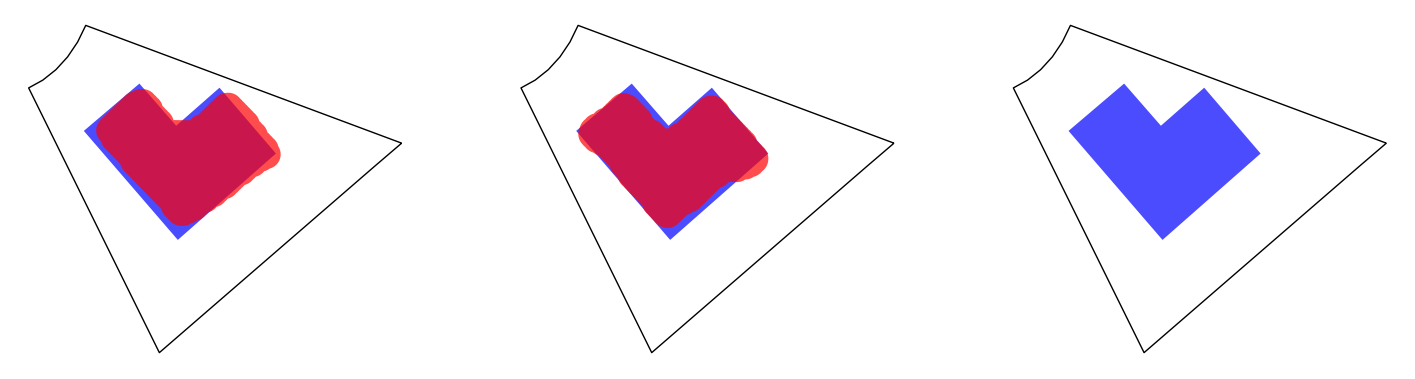

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  180.998678
[-121.86632399999999, 37.372252]


28829040


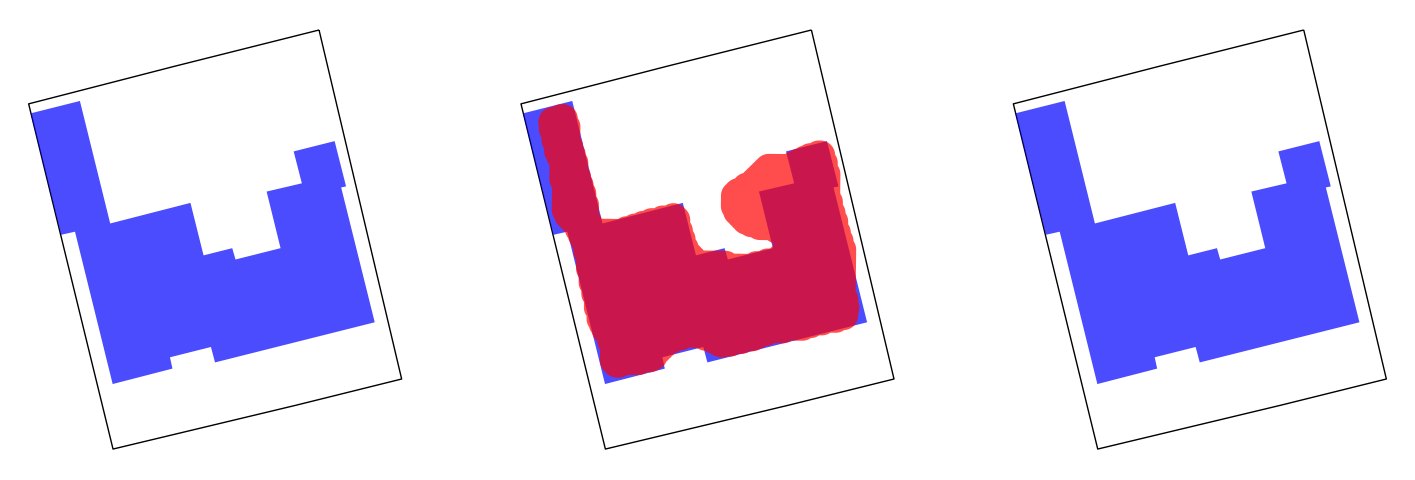

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  522.983455
[-121.91690100000001, 37.28715499999999]


43408108


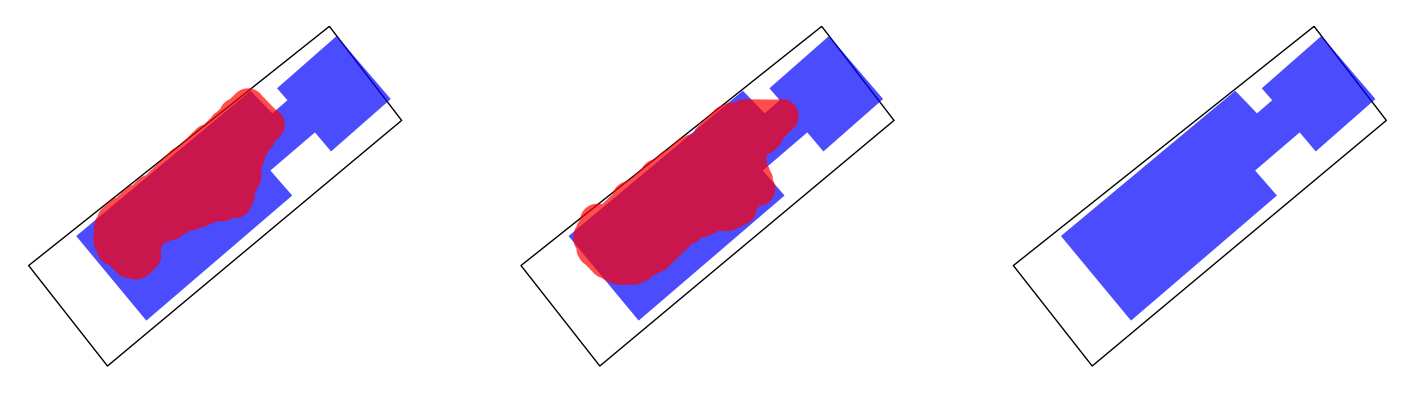

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  270.012332
[-121.87747300000001, 37.318243]


68732010


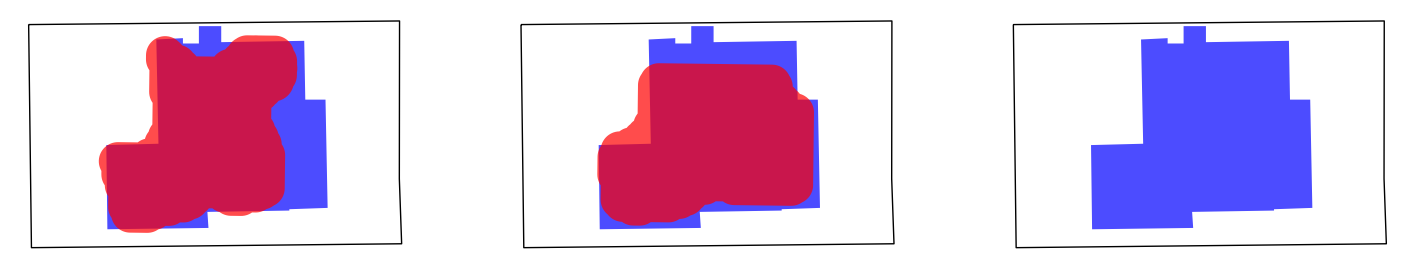

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  227.449285
[-121.831474, 37.240449]


09241004


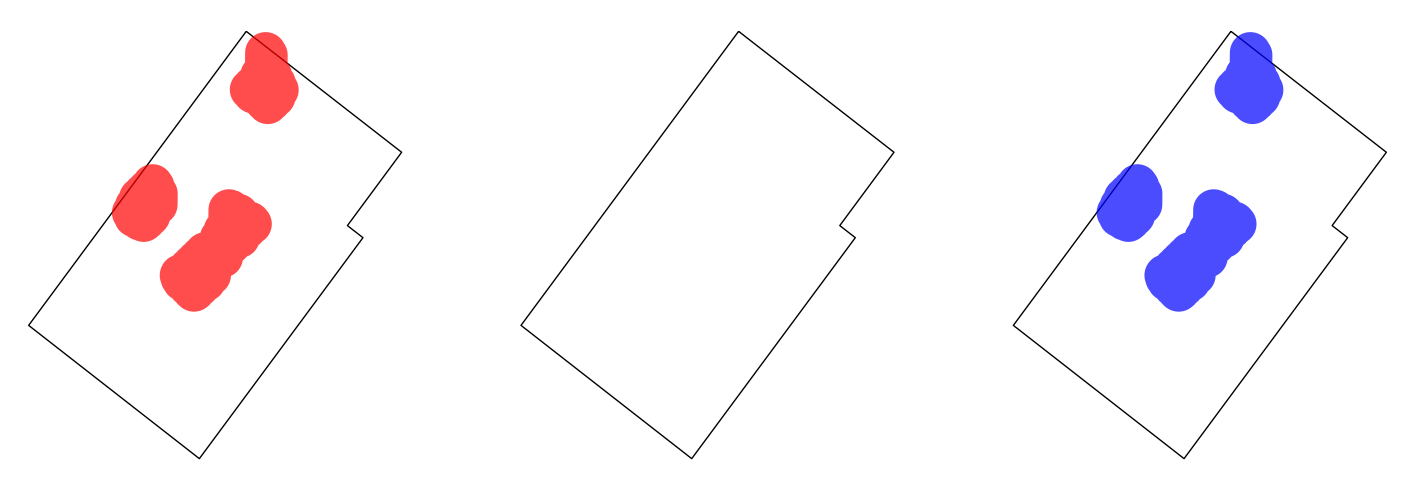

   main_building_flag  OSM_flag exp_OSM_flag exp_2016_flag       area
0                True     False         None          None  44.007722
1               False     False         None          None  26.040422
2               False     False         None          None  22.279455
[-121.88353377758636, 37.40454348258814]


46724006


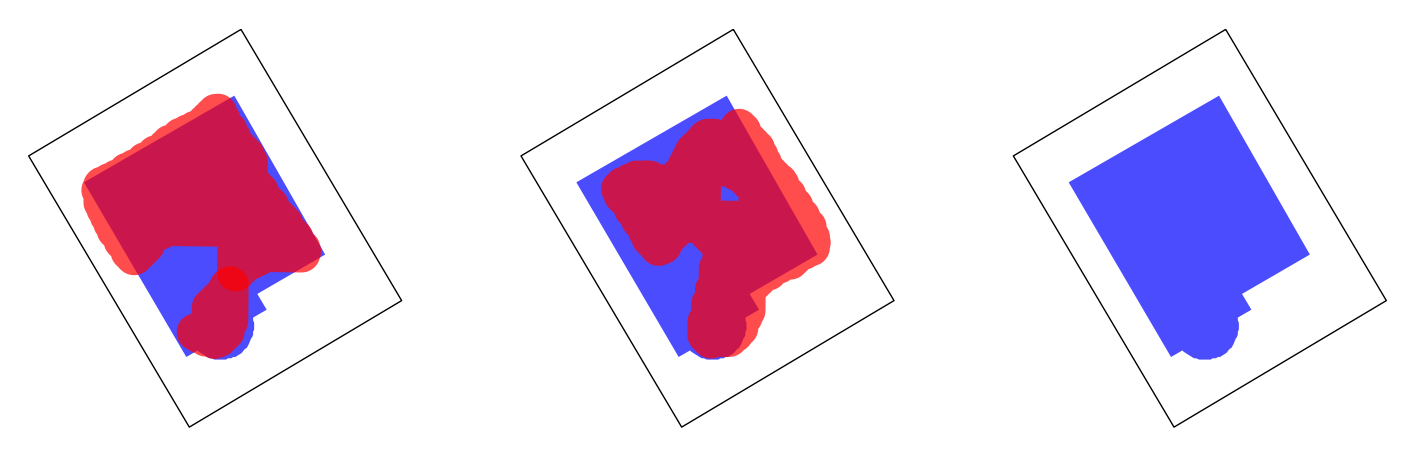

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  247.499639
[-121.884223, 37.336885]


38125025


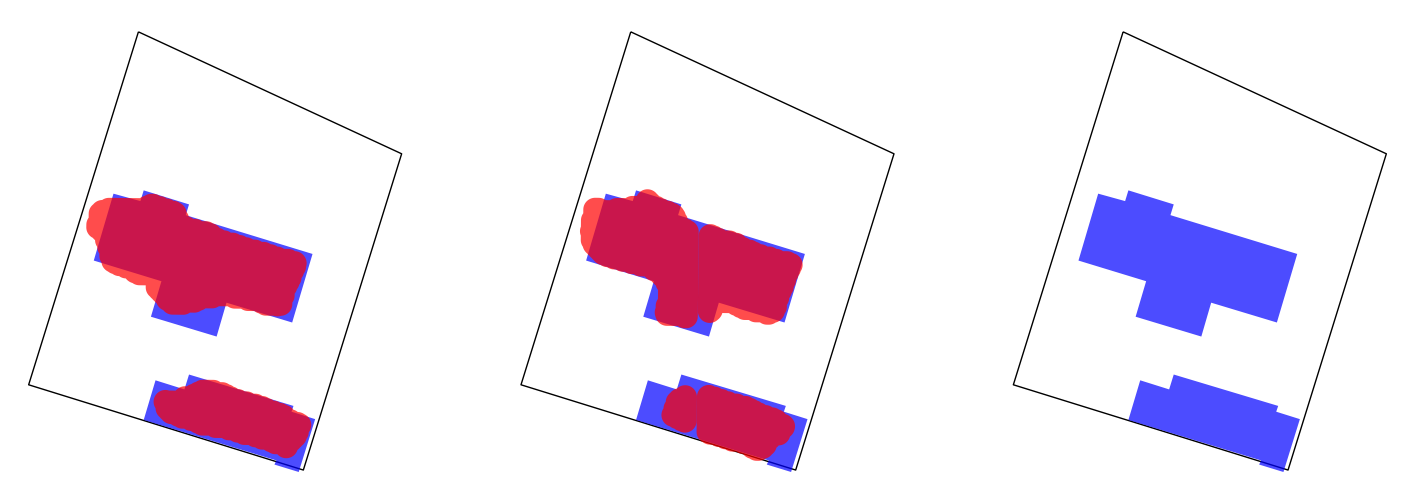

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  322.035471
1               False      True         False          False  159.690565
[-121.991559, 37.303687]


27423034


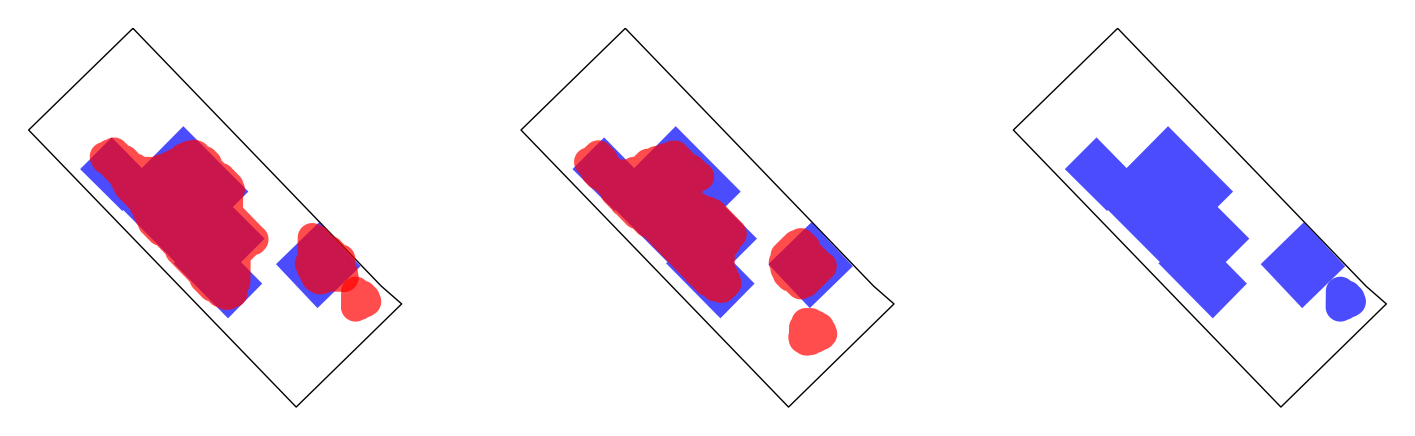

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  194.434110
1               False      True         False          False   42.958577
2               False     False          True           True   16.661187
[-121.930707, 37.32976800000001]


69440031


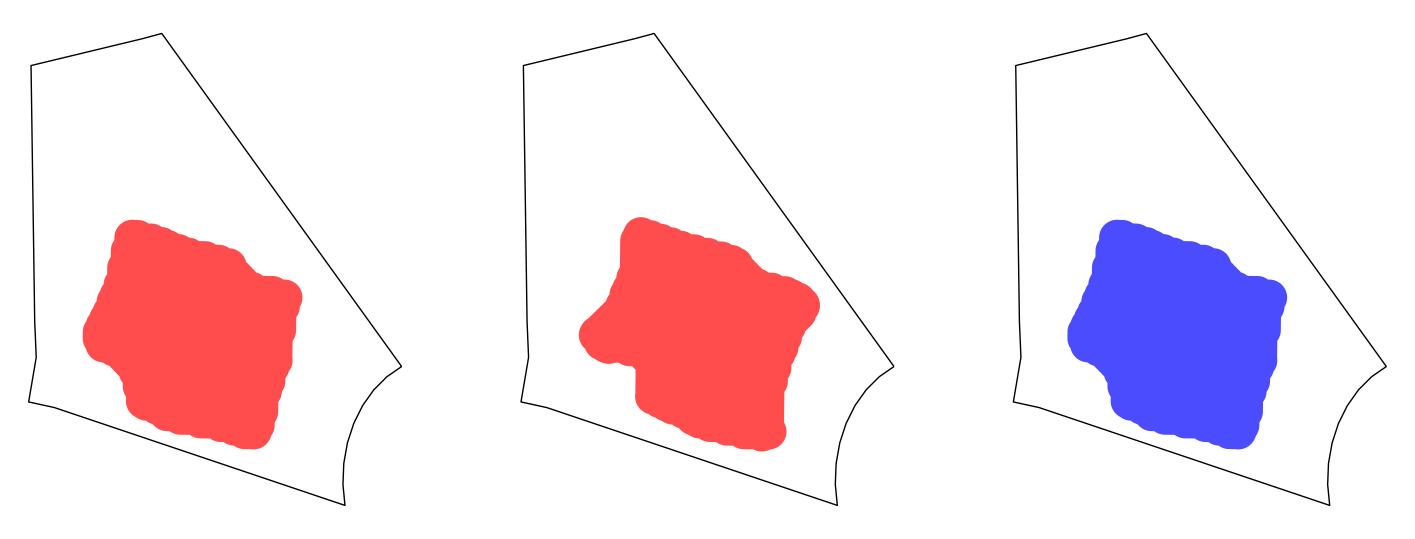

   main_building_flag  OSM_flag exp_OSM_flag  exp_2016_flag        area
0                True     False         None          False  274.105036
[-121.8619484820329, 37.24134842725847]


41907013


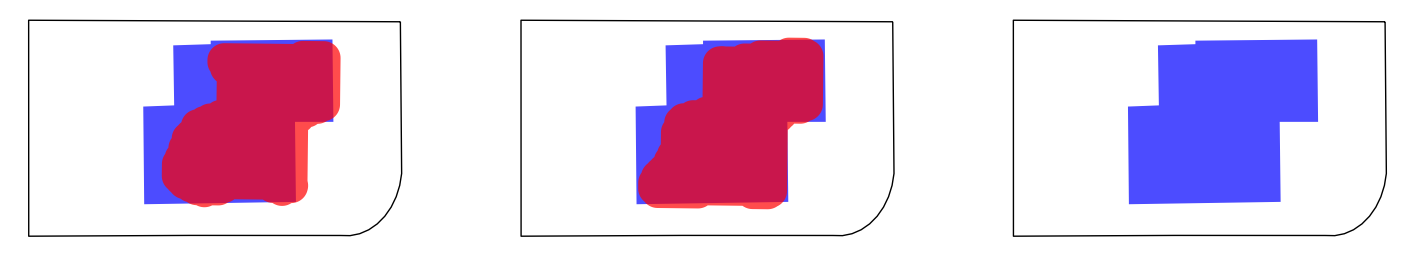

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False          False  228.938257
[-121.92376100000001, 37.262713]


69522026


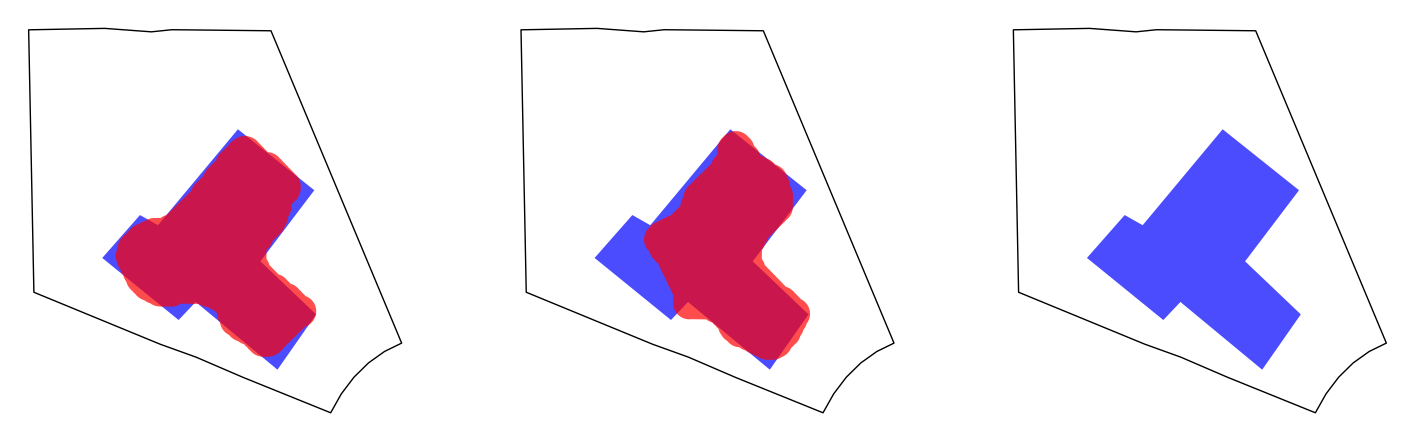

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  242.004044
[-121.835083, 37.234735]


68950029


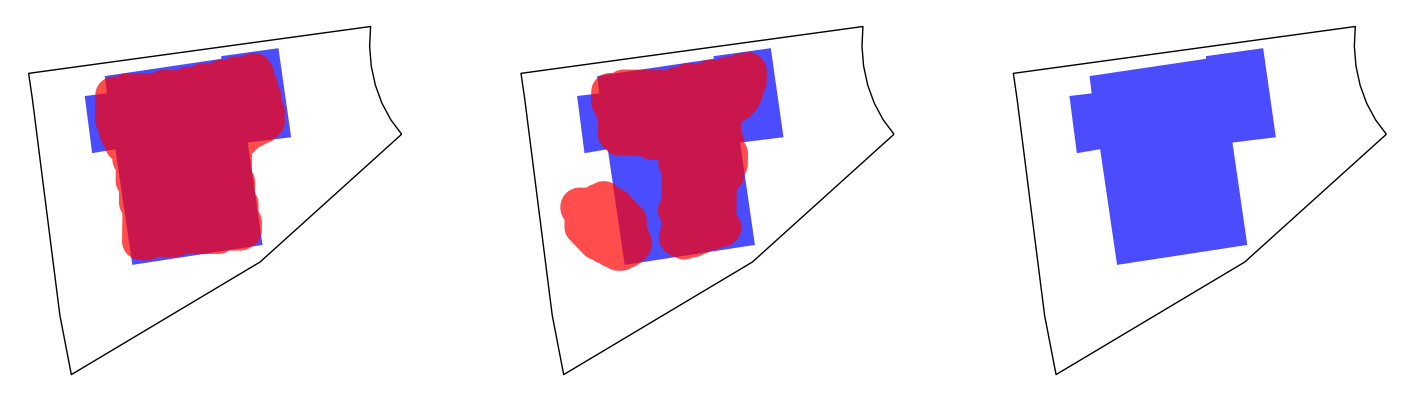

   main_building_flag  OSM_flag  exp_OSM_flag  exp_2016_flag        area
0                True      True         False           True  212.657324
[-121.80679700000002, 37.228569]




In [41]:
for parcel_apn in apns:
    print(parcel_apn)
    parcel_build = run_osm_apn(parcel_apn=parcel_apn, area_threshold=30, flatten_threshold=0.8)
    parcel_build.rename(columns={'expansion_OSM_flag': 'exp_OSM_flag', 'expansion_2016_flag': 'exp_2016_flag'}, inplace=True)
    print(parcel_build[['main_building_flag', 'OSM_flag', 'exp_OSM_flag', 'exp_2016_flag', 'area']].head())
    print(list(parcel_build.iloc[0]['geometry'].exterior.coords[0]))
    print('\n')

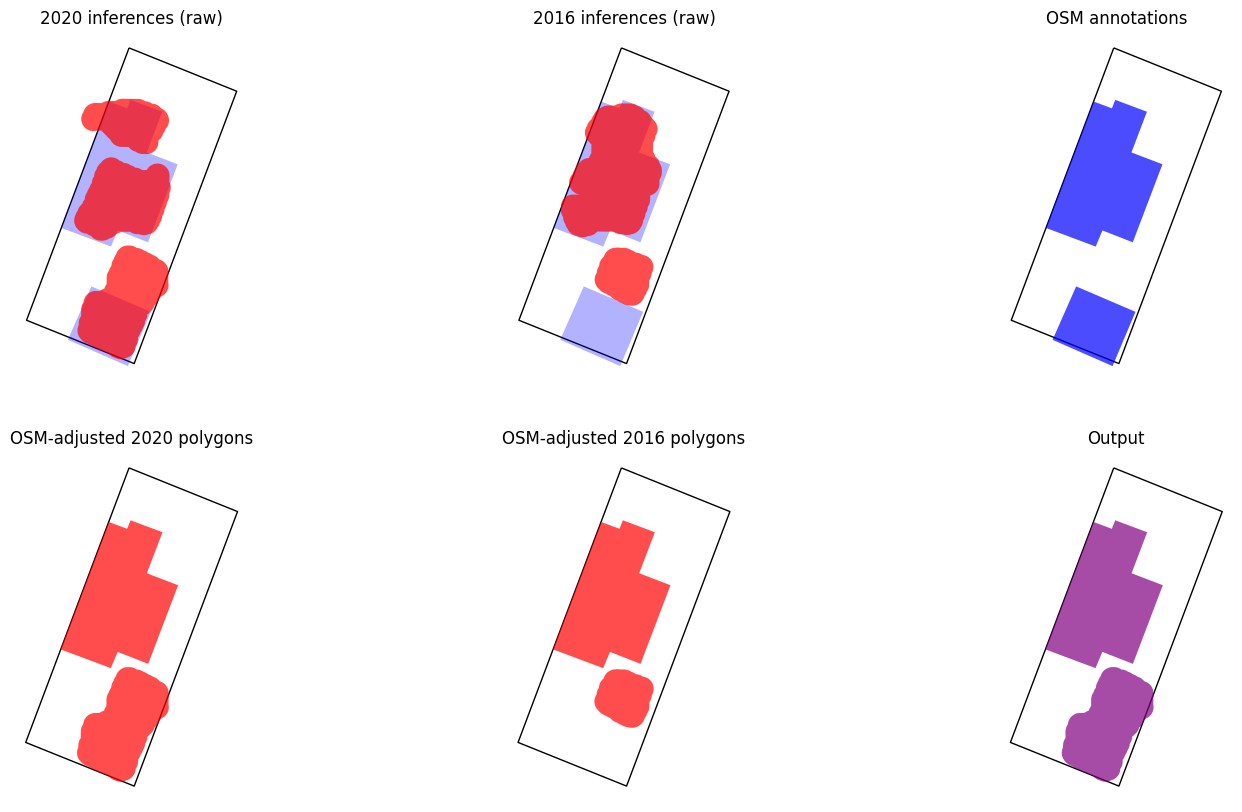

In [34]:
# "Small buildings expansions" -- secondary detached units
parcel_build = run_osm_apn_full_detail(parcel_apn='23044043', area_threshold=40, flatten_threshold=0.80)

In [30]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                 True   
2               False     False                True                 True   

                                            geometry        area  
0  POLYGON ((-121.92701 37.34084, -121.92694 37.3...  176.807545  
2  POLYGON ((-121.92699 37.34073, -121.92699 37.3...  108.403114

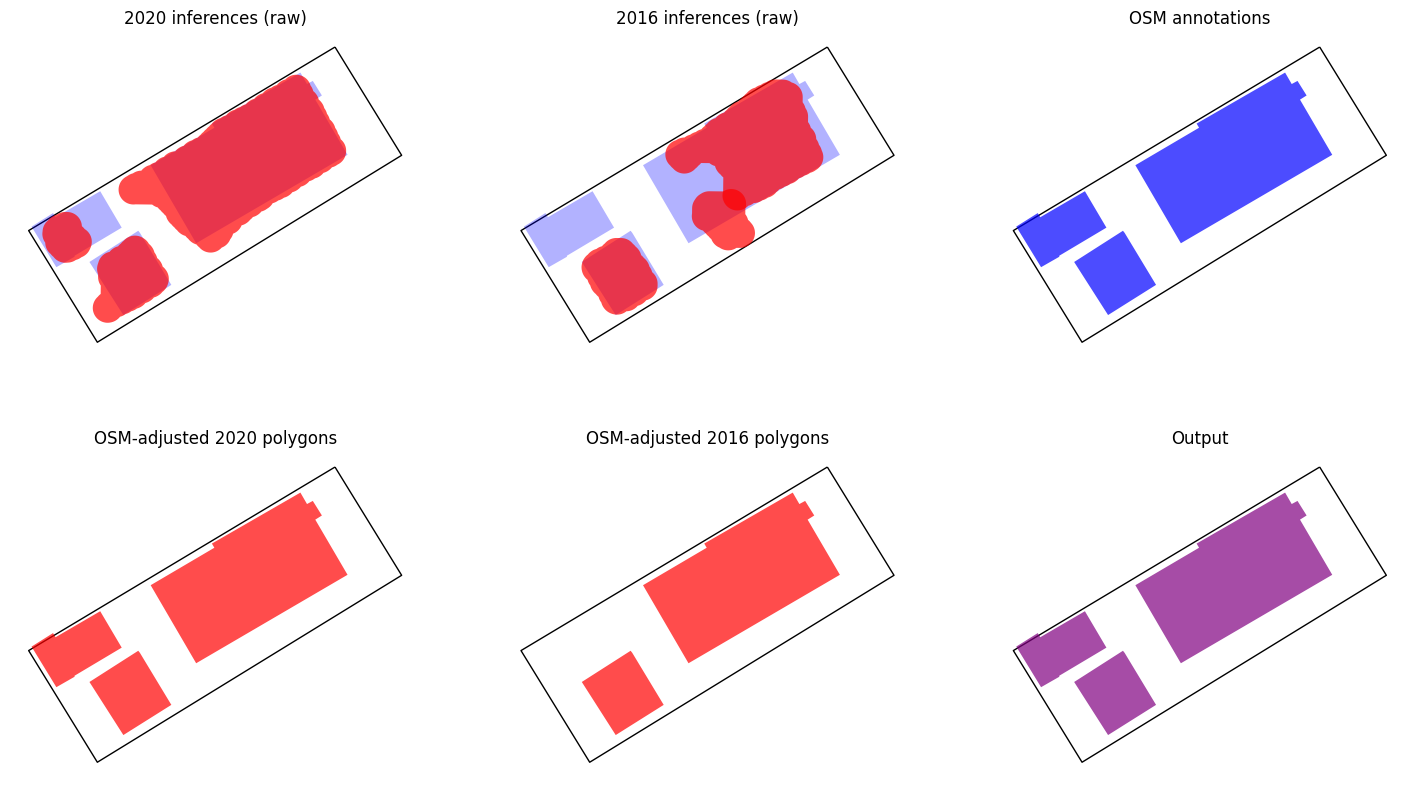

In [35]:
# 2016 constructions
# Note: small building flagged as an expansion as we only use OSM annotations to
# complete 2016 inferences.
parcel_build = run_osm_apn_full_detail(parcel_apn='24960042', area_threshold=30, flatten_threshold=0.80)

In [24]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
1               False      True               False                False   
0                True      True               False                 True   
2               False      True               False                 True   

                                            geometry        area  
1  POLYGON ((-121.87708 37.35002, -121.87702 37.3...   41.469056  
0  POLYGON ((-121.87701 37.35011, -121.87693 37.3...  187.964235  
2  POLYGON ((-121.87715 37.35005, -121.87712 37.3...   38.835141

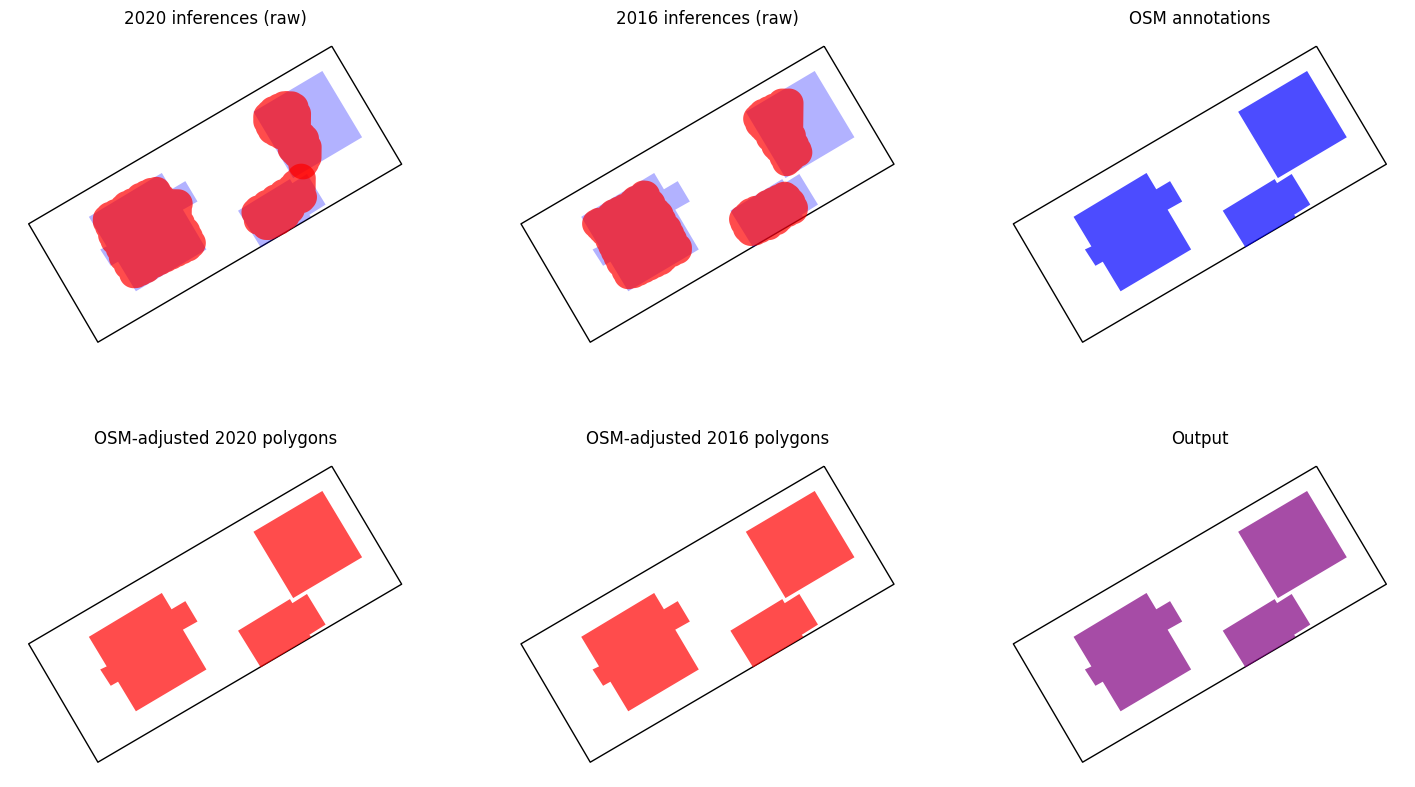

In [33]:
parcel_build = run_osm_apn_full_detail(parcel_apn='24960056', area_threshold=30, flatten_threshold=0.80)

In [495]:
parcel_build

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
0                True      True               False                False   
1               False      True               False                False   
2               False      True               False                False   

                                            geometry       area  
0  POLYGON ((-121.87700 37.34930, -121.87701 37.3...  93.956096  
1  POLYGON ((-121.87683 37.34944, -121.87675 37.3...  73.562811  
2  POLYGON ((-121.87685 37.34935, -121.87679 37.3...  38.378502

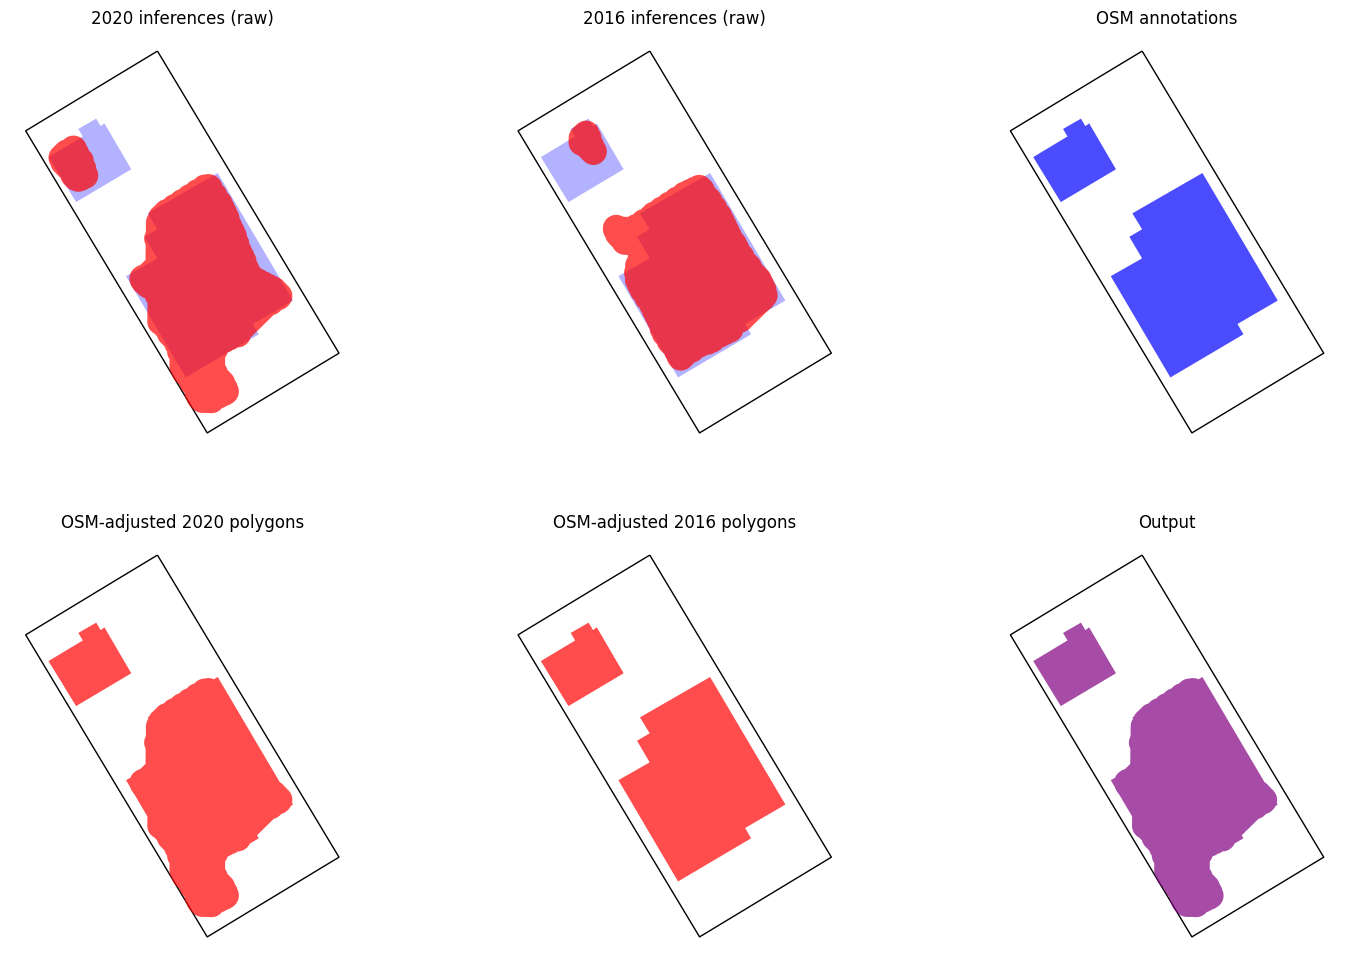

In [22]:
parcel_buildings = run_osm_apn_full_detail(parcel_apn='48114039', area_threshold=30, flatten_threshold=0.80)

## Add satellite imagery to visualizations

In [253]:
#run_osm_apn_full_detail(
#    parcel_apn='48114039', area_threshold=30, flatten_threshold=0.85, 
#    imagery=None)

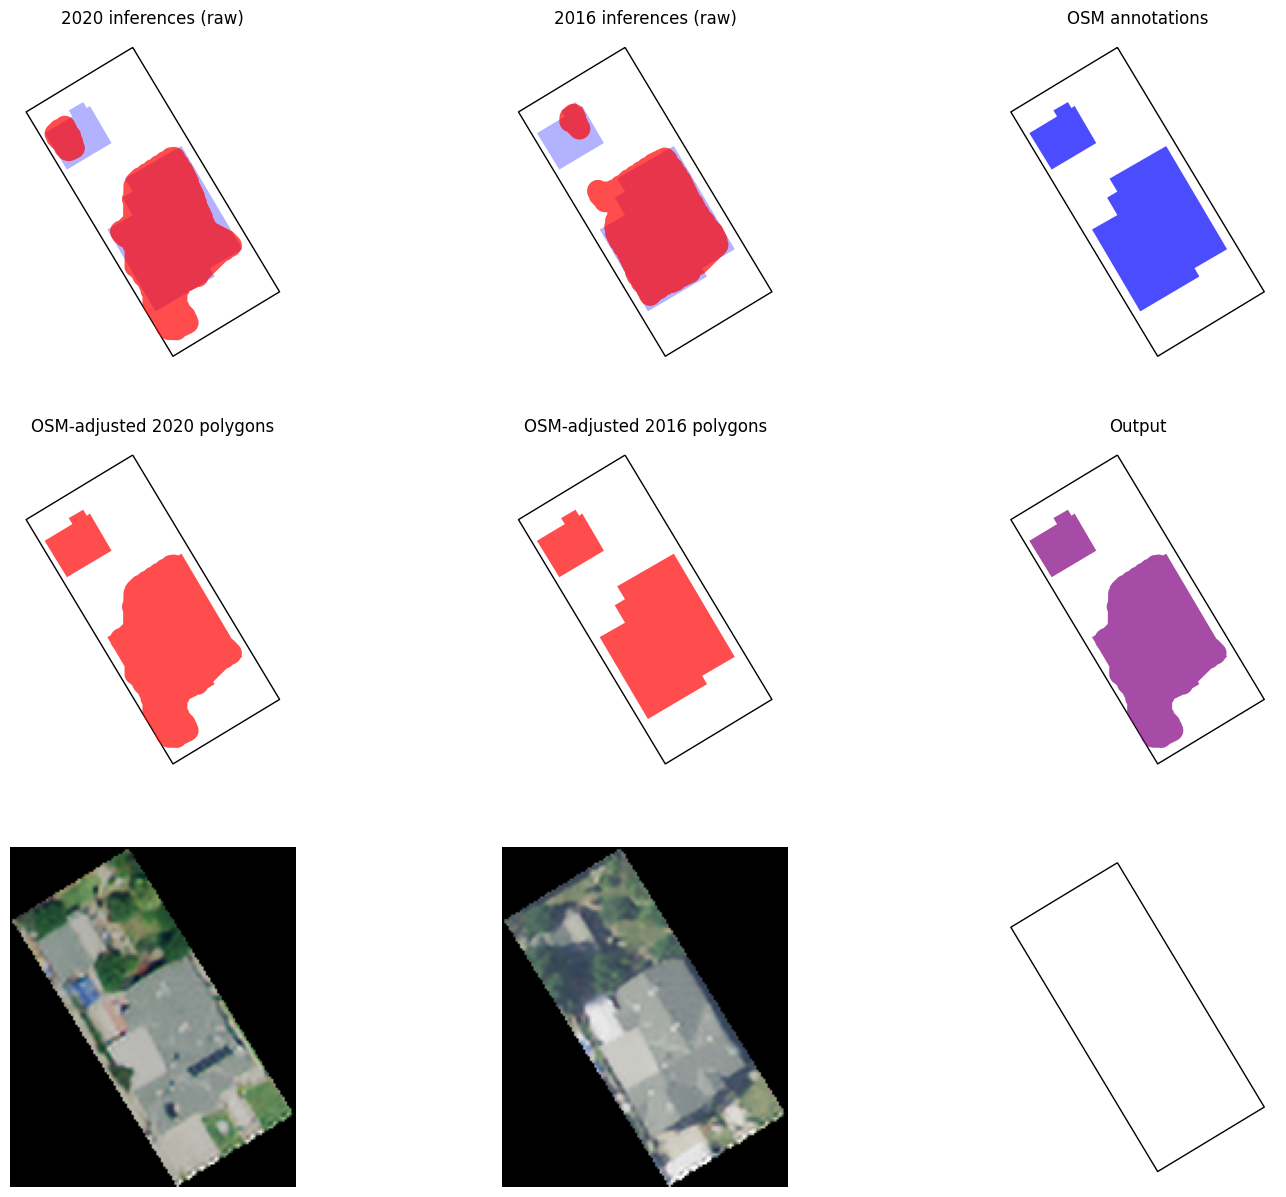

main_building_flag  OSM_flag  expansion_OSM_flag  expansion_2016_flag  \
1               False      True               False                False   
2                True     False                True                 True   

                                            geometry        area  
1  POLYGON ((-121.85899 37.34946, -121.85894 37.3...   50.668790  
2  POLYGON ((-121.85888 37.34933, -121.85888 37.3...  313.645159

In [279]:
run_osm_apn_full_detail(
    parcel_apn='48114039', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})


## Document ground truth instances

In [12]:
def ground_truth_grid_check(parcel_apns, gt_type):
    num_parcels = len(parcel_apns)
    fig, axs = plt.subplots(ncols=4, nrows=int(2 * num_parcels), figsize=(10, int(num_parcels * 4)))
    
    i = 0
    for parcel_apn in parcel_apns:
        parcel_builds = run_osm_apn_full_detail(
            parcel_apn=parcel_apn, area_threshold=30, flatten_threshold=0.85, 
            sat_imagery=None, attach=(fig, (axs[i][0:3], axs[i+1][0:3])), title=False)
        
        # Pass/fail
        main_build = parcel_builds.loc[parcel_builds['main_building_flag'] == True].iloc[0]
        main_build_expansion = main_build['expansion_2016_flag']
        
        small_build = parcel_builds.loc[parcel_builds['main_building_flag'] != True]
        small_build_expansion = small_build['expansion_2016_flag'].sum()
        
        
        if gt_type == 'Negative small build':
            pass_test = (small_build_expansion == 0)
        elif gt_type == 'Positive small build':
            pass_test = (small_build_expansion > 0)
        elif gt_type == 'Positive main build':
            pass_test = main_build_expansion 
        elif gt_type == 'Negative main build':
            pass_test = not main_build_expansion
        else:
            raise Exception('[ERROR] Check ground truth type.')
        
        # Add pass/fail info
        axs[i][3].axis('off')
        axs[i+1][3].axis('off')
        
        axs[i+1][3].text(0.5, 0.5, gt_type, style='italic')
        color_test = 'green' if pass_test else 'red'
        pass_test = 'Pass' if pass_test else 'Fail'
        axs[i+1][3].text(0.5, 0.25, pass_test, color=color_test)
        
        i += 2
    plt.show()

In [13]:
case_dict = load_ground_truth_parcels()
ps_gt_grid = case_dict['Positive small build']
ns_gt_grid = case_dict['Negative small build']
pm_gt_grid = case_dict['Positive main build']
nm_gt_grid = case_dict['Negative main build']

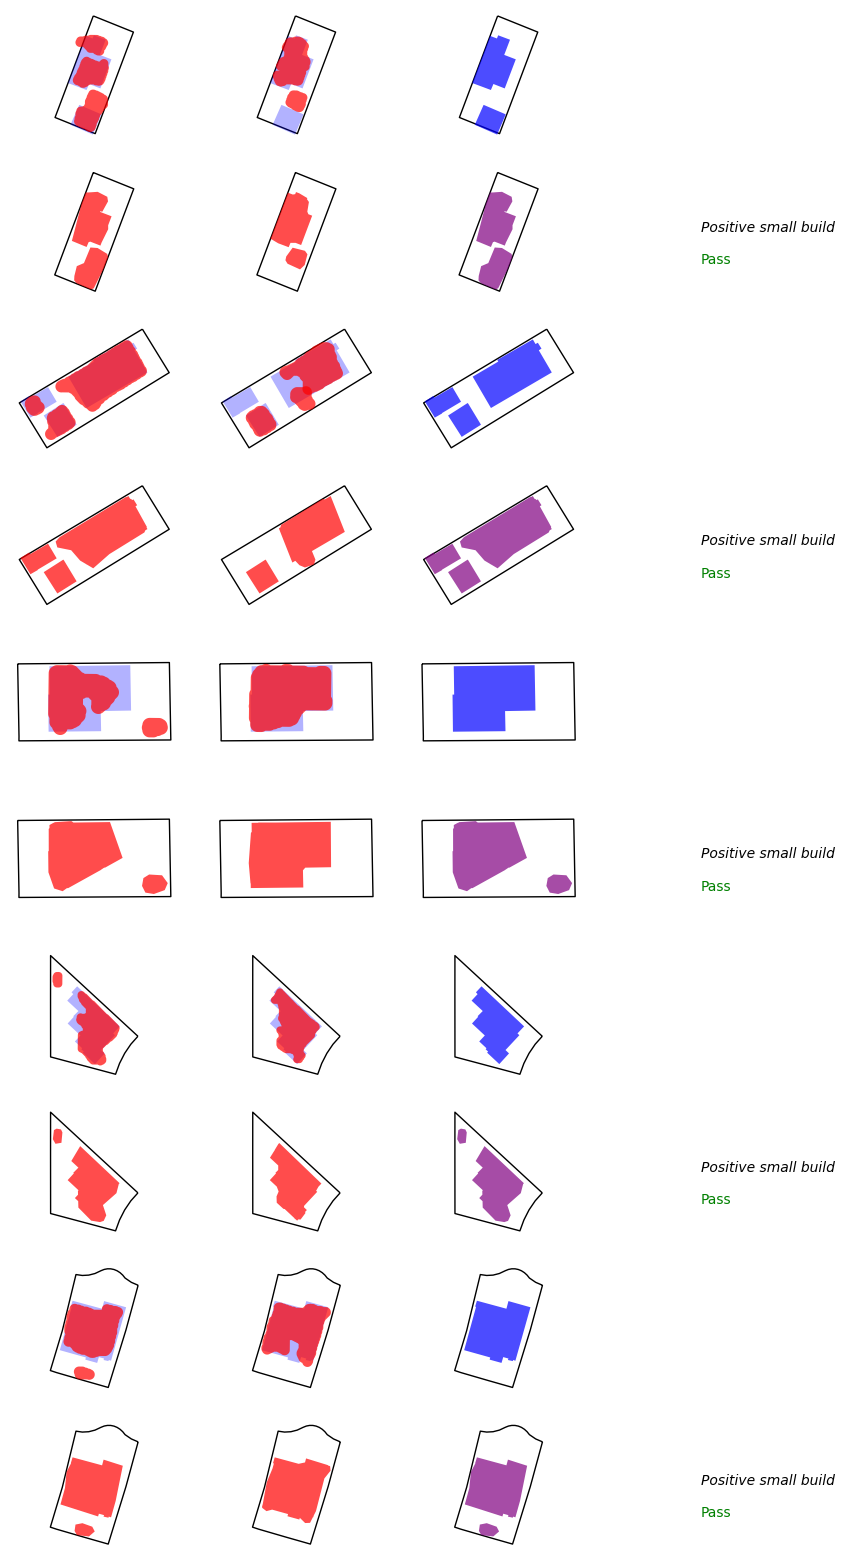

In [14]:
ground_truth_grid_check(*ps_gt_grid)

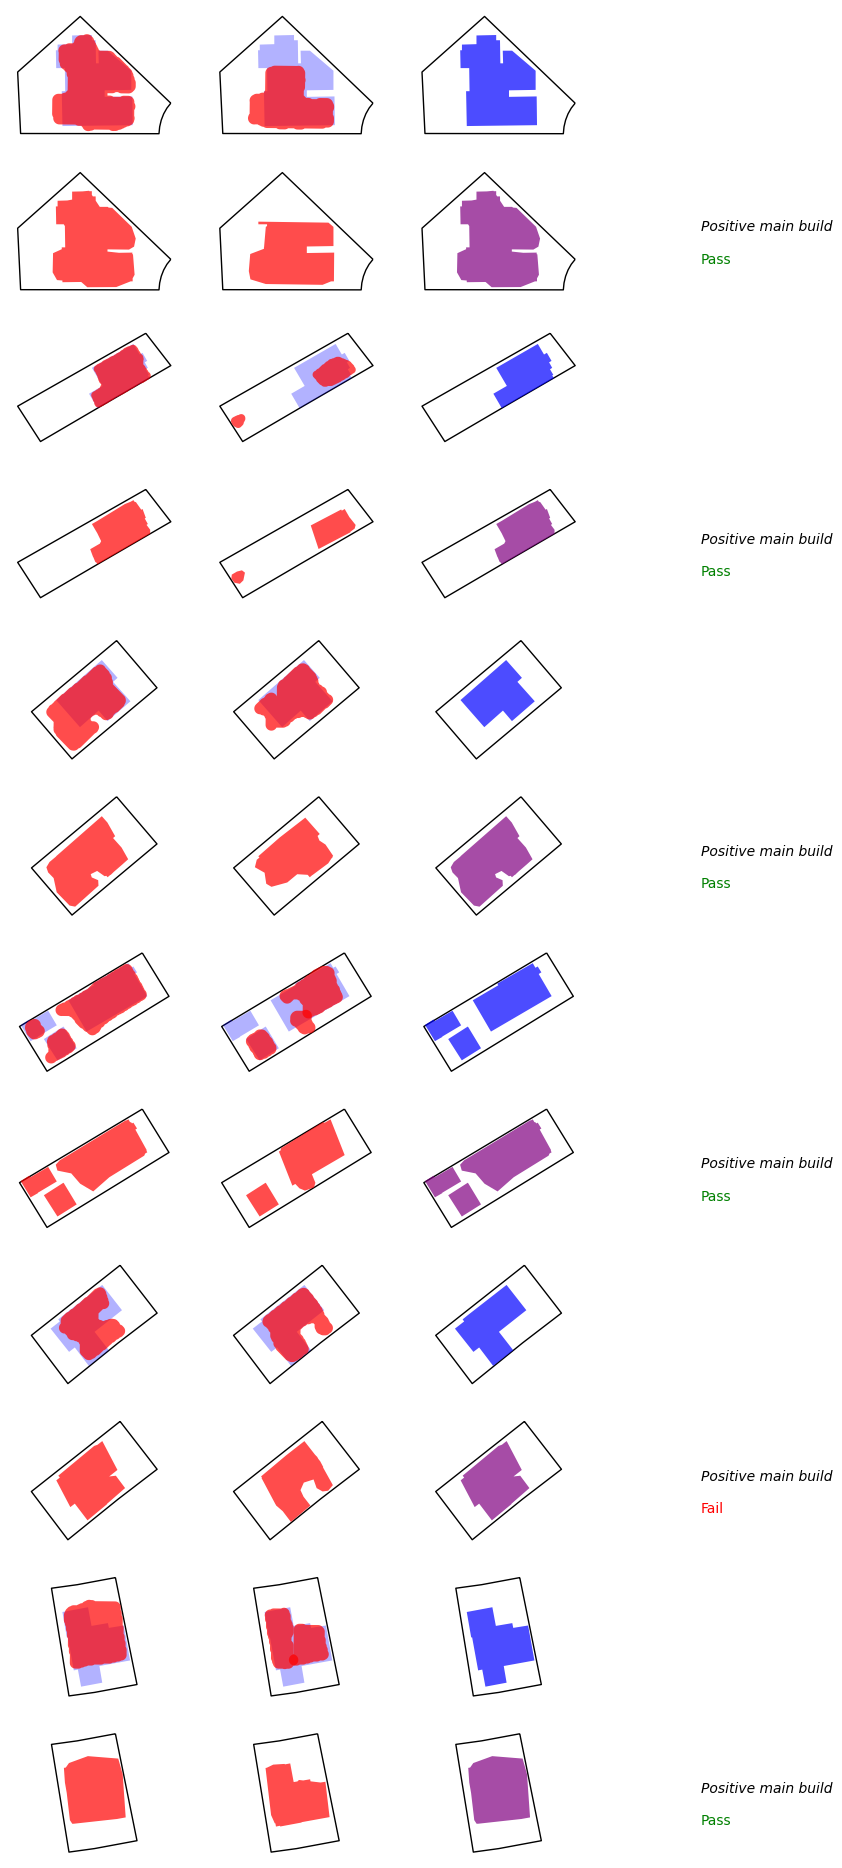

In [15]:
ground_truth_grid_check(*pm_gt_grid)

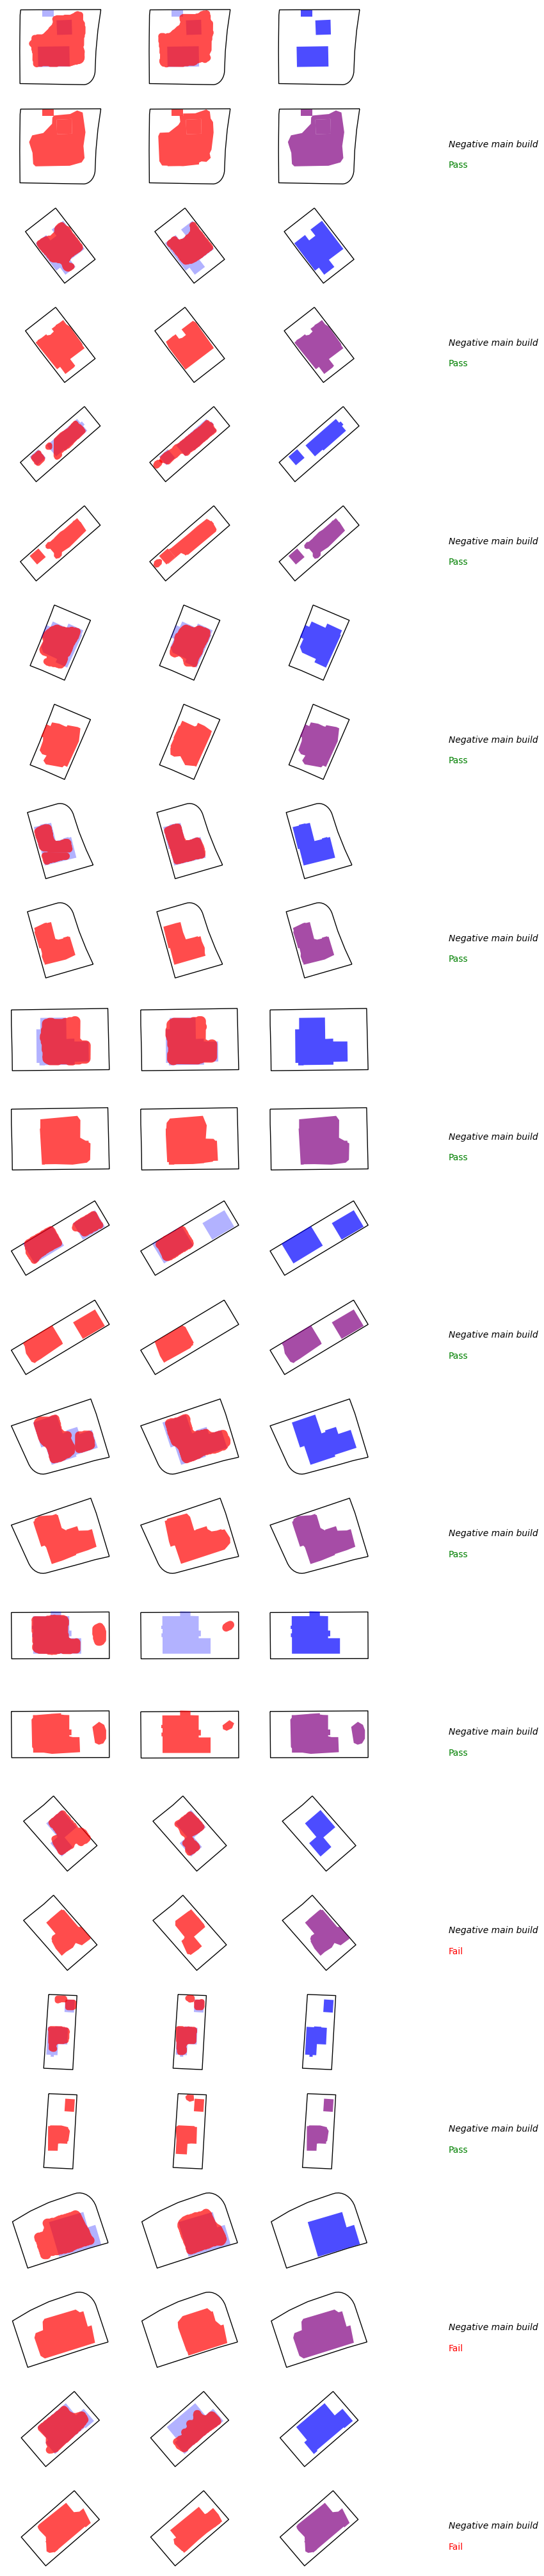

In [16]:
# After minimum rotated rectangle
ground_truth_grid_check(*nm_gt_grid)

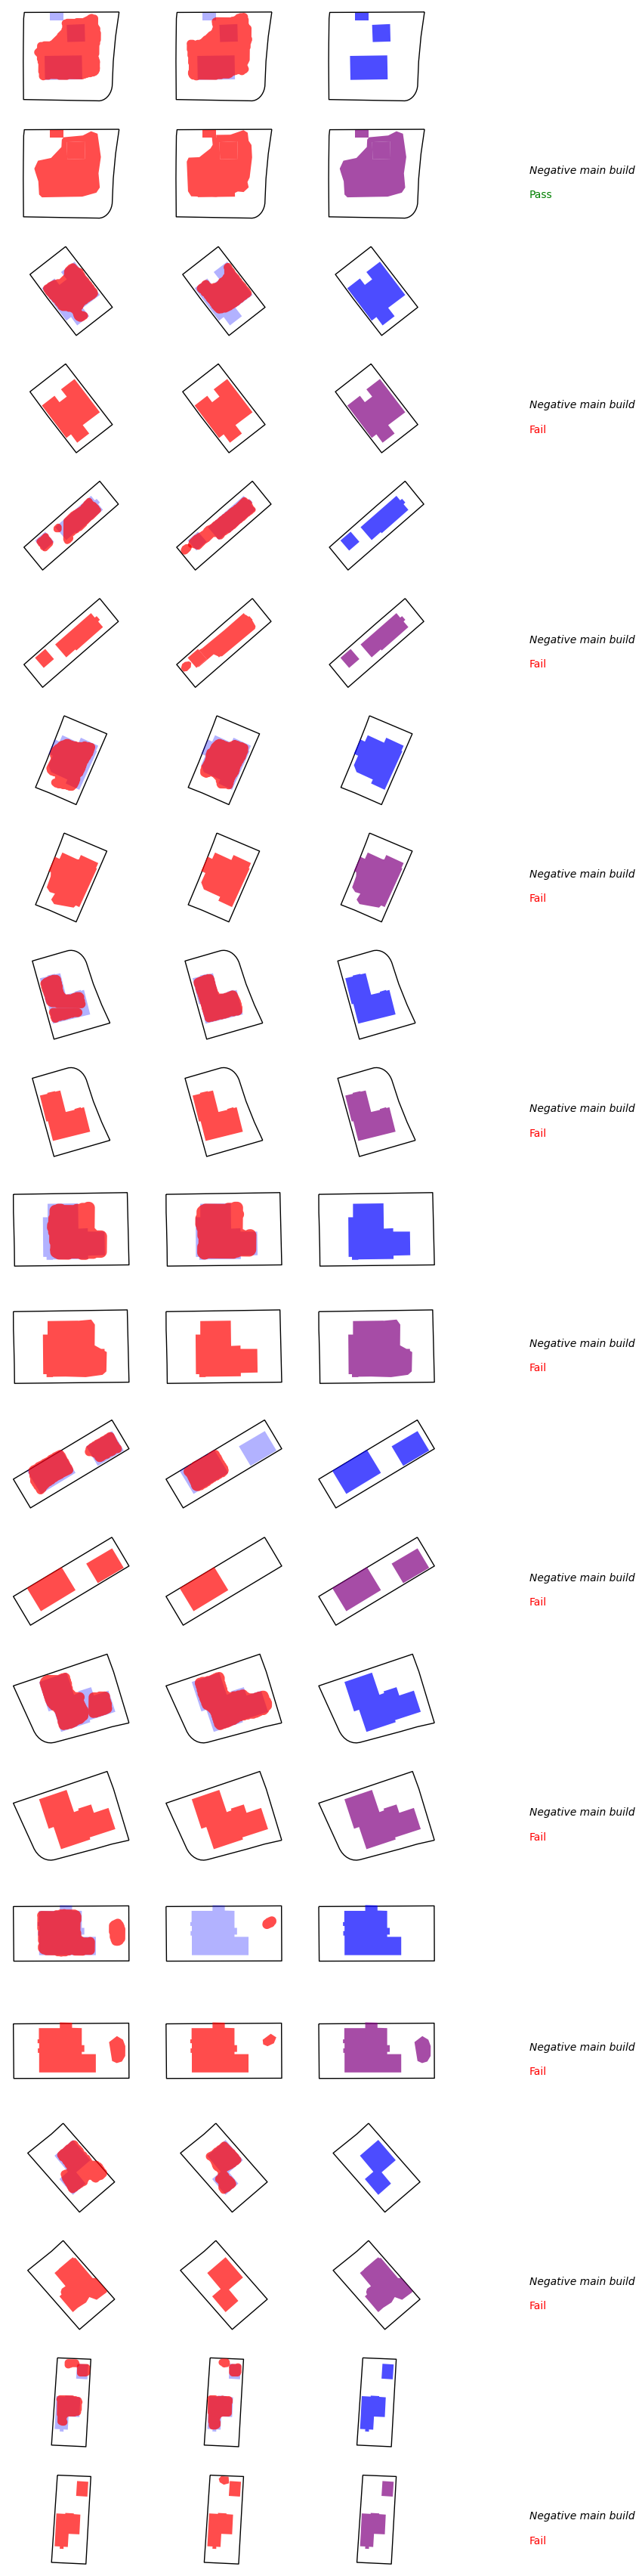

In [114]:
# Prior to minimum rotated rectangle
ground_truth_grid_check(*nm_gt_grid)

## Check imagery alignment in time

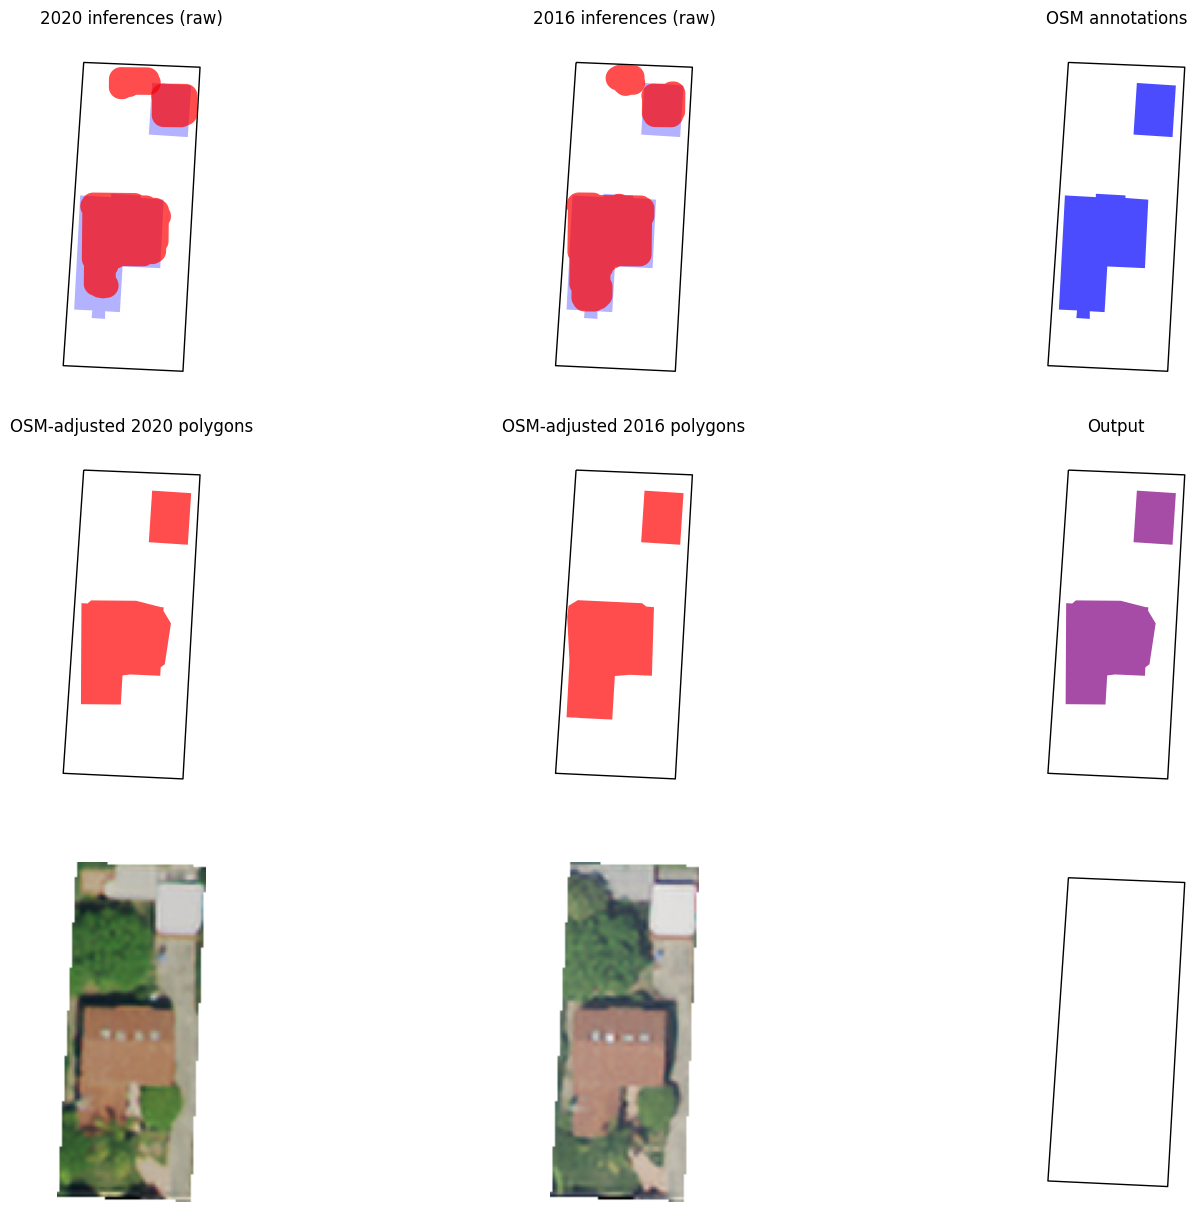

main_building_flag  OSM_flag  expansion_OSM_flag  diff_OSM_value  \
1               False      True               False        0.000000   
0                True     False               False        1.567373   

   expansion_2016_flag  diff_2016_value  \
1                False         0.000000   
0                False         4.049986   

                                            geometry        area  
1  POLYGON ((-121.90006 37.31736, -121.90012 37.3...   34.933291  
0  POLYGON ((-121.90021 37.31730, -121.90020 37.3...  127.816835

In [14]:
run_osm_apn_full_detail(
    parcel_apn='26444013', area_threshold=30, flatten_threshold=0.85, 
    sat_imagery={'img_fp': IMG_FP, 'tif_fp': TIF_FP, 'sj_parcels_res': sj_parcels_res, 'tiles_gdf': tiles_gdf})

## Refine main expansion events

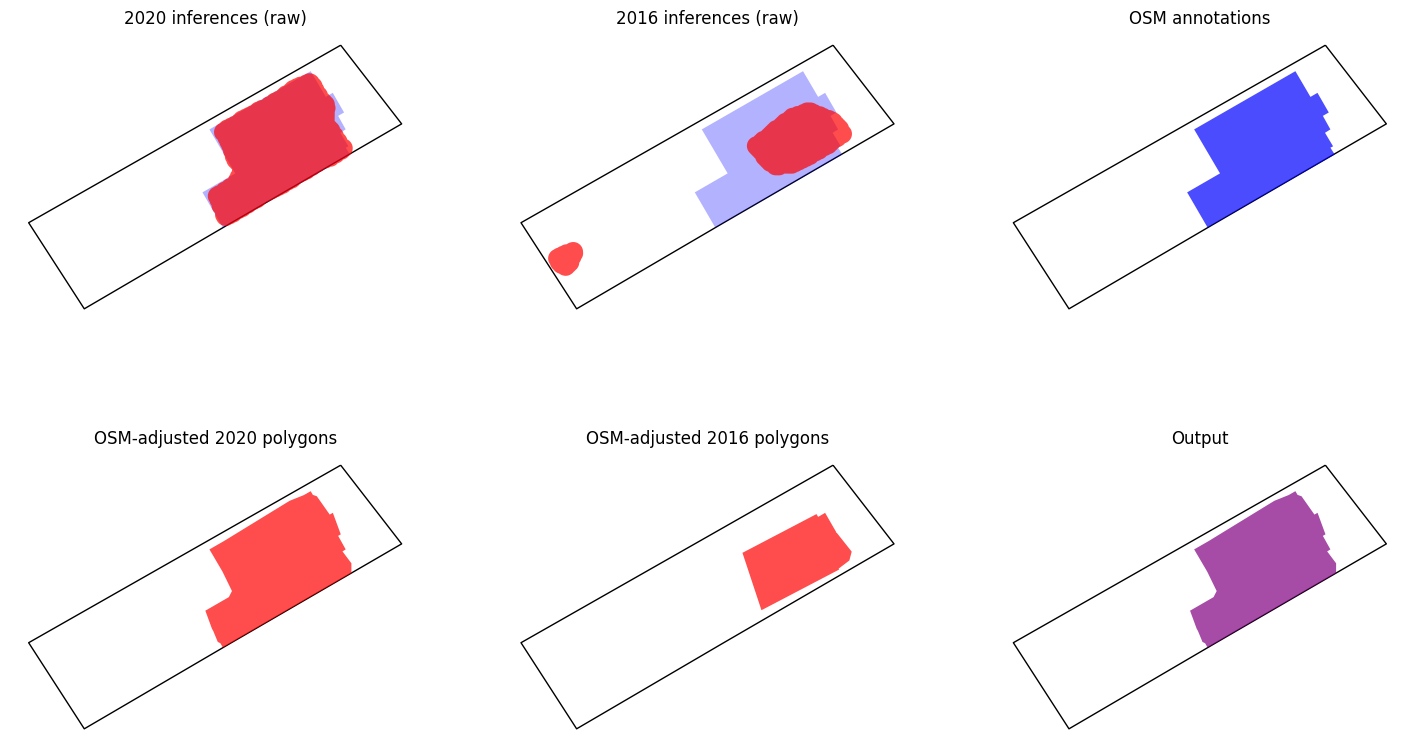

main_building_flag  OSM_flag  expansion_OSM_flag  diff_OSM_value  \
0                True     False               False             0.0   

   expansion_2016_flag  diff_2016_value  \
0                 True       186.779617   

                                            geometry        area  
0  POLYGON ((-121.89747 37.30701, -121.89747 37.3...  337.634274

In [228]:
parcel_apn = '27406055'
#parcel_apn = '26433013'
#parcel_apn = '23044043'
parcel_apn = '42905080'
inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, permits_parcel = parcel_level_data(parcel_apn, sj_parcels_res, sj_parcel_permit)
parcel_bounds = sj_parcels_res[sj_parcels_res['APN'] == parcel_apn]

gpd_cols = ['main_building_flag', 'OSM_flag', 'expansion_OSM_flag', 'expansion_2016_flag', 'geometry']
parcel_buildings = gpd.GeoDataFrame(geometry=[], columns=gpd_cols)

# Drop OSM index_left column
if osm_buildings_parcel is not None and 'index_left' in osm_buildings_parcel.columns:
    osm_buildings_parcel.drop('index_left', axis=1, inplace=True)

# Identify main buildings
parcel_builds, parcel_main_geoms = identify_main_buildings(
    inferred_buildings_2020_parcel, inferred_buildings_2016_parcel, osm_buildings_parcel, parcel_bounds)
ib_2020_parcel, ib_2016_parcel, osm_parcel = parcel_builds
ib_2020_main_geom, ib_2016_main_geom, osm_main_geom = parcel_main_geoms

run_osm_apn_full_detail(
    parcel_apn=parcel_apn, area_threshold=30, flatten_threshold=0.85, 
    sat_imagery=None)

In [229]:
# Visualize mrr
osm_main_build = osm_main_geom
inf_main_build_2020 = ib_2020_main_geom
inf_main_build_2016 = ib_2016_main_geom

inf_mrr = inf_main_build_2016.minimum_rotated_rectangle
inf_union = inf_mrr.intersection(osm_main_build)
inf_union = inf_union.union(inf_main_build_2016)

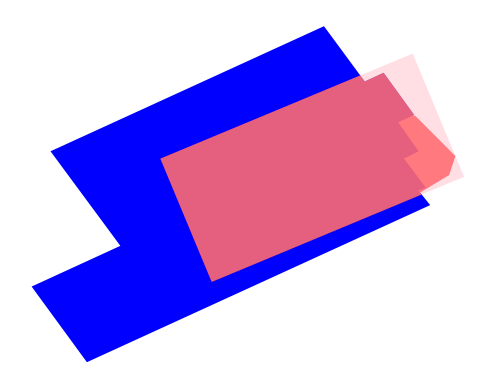

In [231]:
fig, ax = plt.subplots()

gpd.GeoDataFrame(geometry=[osm_main_build]).plot(ax=ax, color='blue')
gpd.GeoDataFrame(geometry=[inf_main_build_2016]).plot(ax=ax, color='red', alpha=0.8)
gpd.GeoDataFrame(geometry=[inf_mrr]).plot(ax=ax, color='pink', alpha=0.5)
plt.axis('off')
plt.show()

In [232]:
# Visualize differences
base_build = inf_main_build_2016
union_build = inf_main_build_2020.union(base_build)

diff_build = gpd.GeoDataFrame(geometry=[union_build.difference(base_build)], crs='EPSG:4326')
diff_build_OG = diff_build.copy()

# Break up polygons and remove crusts
diff_build = diff_build.to_crs('EPSG:26910')
diff_build['geometry'] = diff_build.geometry.buffer(-0.2)
diff_build = diff_build.explode(ignore_index=True, index_parts=False)
diff_build['geometry'] = diff_build.geometry.buffer(0.2)

diff_build['geometry'] = diff_build['geometry'].apply(
    lambda geom: geom.buffer(-0.5).buffer(0.5*1.1).intersection(geom))

diff_build = diff_build.to_crs('EPSG:4326')

# Return largest polygon
diff_build['area'] = diff_build.to_crs('EPSG:26910').area

In [233]:
diff_build

geometry        area
0  POLYGON ((-121.89751 37.30699, -121.89751 37.3...  186.779617

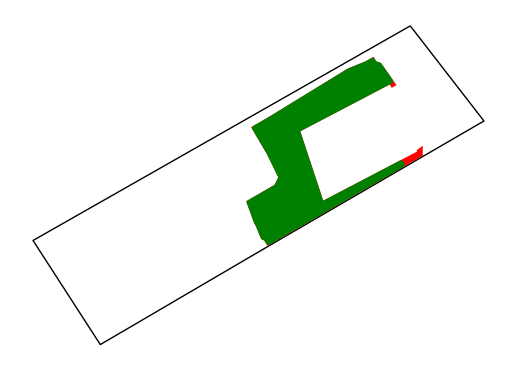

In [234]:
fig, ax = plt.subplots()
parcel_bounds.plot(ax=ax, facecolor='white', edgecolor='black')
diff_build_OG.plot(ax=ax, color='red')
diff_build.plot(ax=ax, facecolor='green')
plt.axis('off')
plt.show()